In [628]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image  
import pydotplus
import timeit
import seaborn as sns


# Classificatino
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression

import scikitplot as skplt
import scipy.cluster.hierarchy as sch
from scipy.stats import entropy
from scipy.spatial.distance import cdist

%matplotlib inline

# Sometimes this needs to be run twice so that size is assigned ...
size = plt.rcParams["figure.figsize"] = [20, 15]
font = plt.rcParams.update({'font.size': 22})

In [447]:
def my_cluster(dev, test, n=6):
    # First we scale the data for better clusters
    X_train_scaled = StandardScaler().fit_transform(dev)
    X_test_scaled = StandardScaler().fit_transform(test)

    # Fit clusters on development, and apply to both development and test
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train_scaled)
    dev_cluster = kmeans.predict(X_train_scaled)
    test_cluster = kmeans.predict(X_test_scaled)

    # Merge these back to the development and test data
    return dev.assign(cluster = dev_cluster), test.assign(cluster = test_cluster)

In [28]:
def ROC(xtest, ytest, fitter, plot_label='', roc_title=''):
    prob = fitter.predict_proba(xtest)[:, 1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, prob, pos_label=1)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # create plot
    plt.plot(false_positive_rate, true_positive_rate, label=plot_label, linewidth=7)

    # create plot
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess', linewidth=7)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if roc_title=='':
        plt.title('ROC Curve, with area of ' + str(round(roc_auc, 2)) + ' under the curve')
    plt.xlim([-0.02, 1])
    plt.ylim([0, 1.02])
    plt.legend(loc="lower right")
    size
    font
    plt.show()

In [29]:
def train_test_AUC(local_range, train, test, local_label=''):
    line1, = plt.plot(local_range, train, "b", label="Train AUC")
    line2, = plt.plot(local_range, test, "r", label="Test AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("Area under the curve score")
    plt.xlabel(local_label)
    plt.xticks(local_range)
    size
    font
    plt.show()

# Import the panel data, split it into training and test data

In [276]:
data_base = pd.read_csv("for_python_panel_v1.csv")
col_of_pred = 8

## Some Data exploration
Most data exploration have already been done, but we would like to for example look at variables that are highly correlated

In [372]:
features_only = data_base.iloc[:, col_of_pred :]

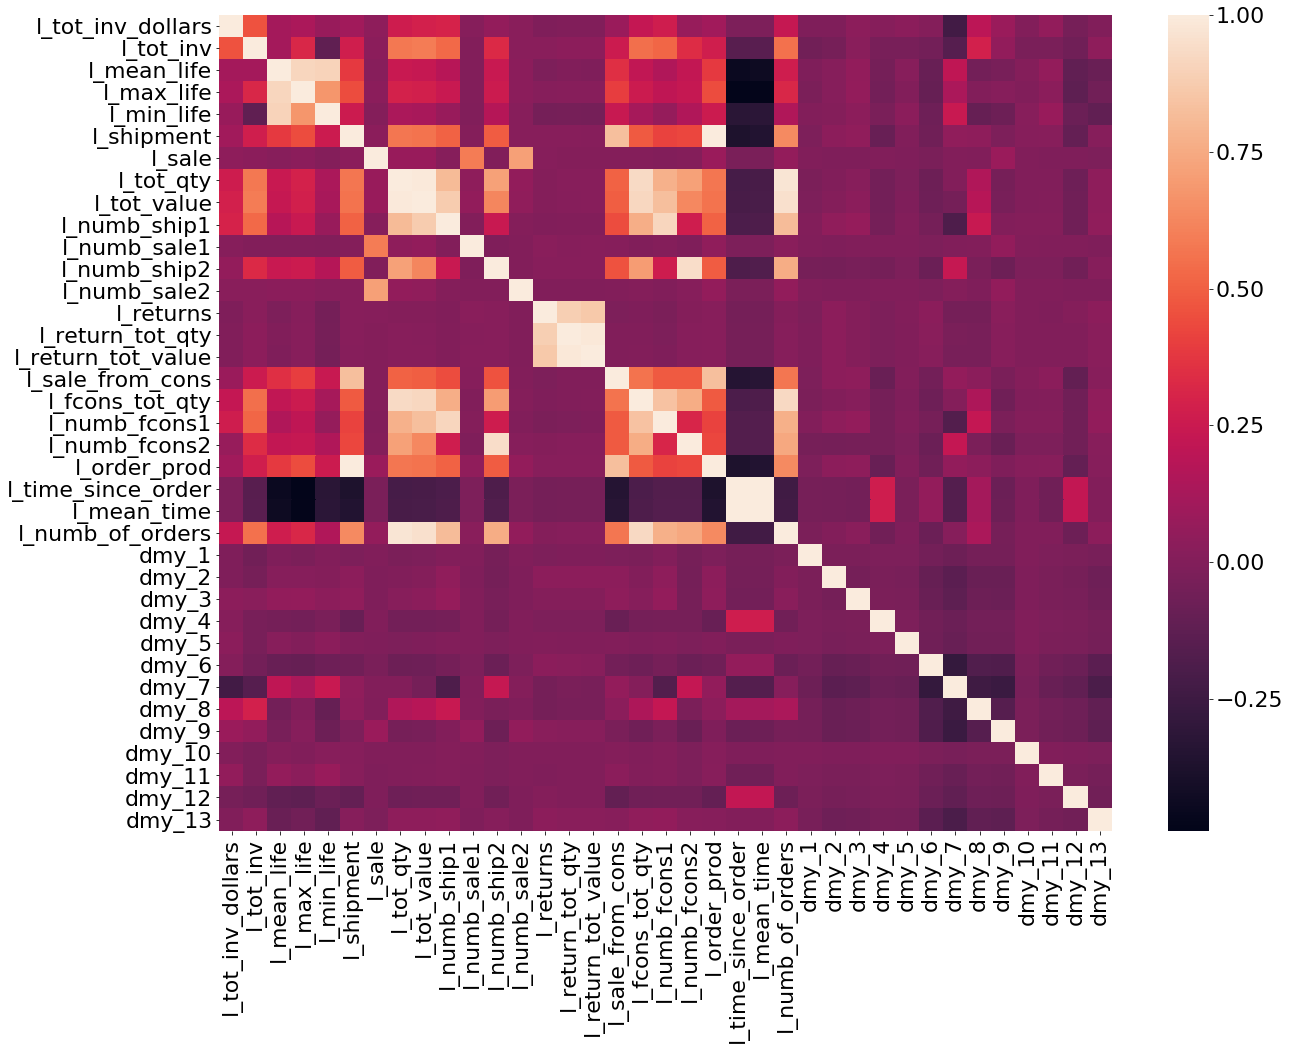

In [381]:
corr_matrix = features_only.corr().abs()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

There are some variables that are highly correlated. We remove the diagonal and see which variables that might be.

In [382]:
# FROM: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# Create correlation matrix
corr_matrix = features_only.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [387]:
print(to_drop)

['l_tot_value', 'l_numb_ship1', 'l_numb_ship2', 'l_return_tot_value', 'l_fcons_qty_prod2', 'l_fcons_tot_value', 'l_numb_fcons1', 'l_numb_fcons2', 'l_order_prod', 'l_mean_time', 'l_numb_of_orders']


We first do a PCA analysis, in order to visualize the data. We choose the "order_prod" to visualize.

In [31]:
X = data_base.iloc[:, col_of_pred :]
X_scaled = StandardScaler().fit_transform(X)
y = data_base["order_prod"]

In [32]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
principalDf = pd.DataFrame(data = X_pca, columns = ["PC 1", "PC 2", "PC 3" ])
PCA_plot = principalDf.assign(order_prod = y)
print("Of the variance we explain: " + str(pca.explained_variance_ratio_))

Of the variance we explain: [0.24004679 0.104799   0.08401203]


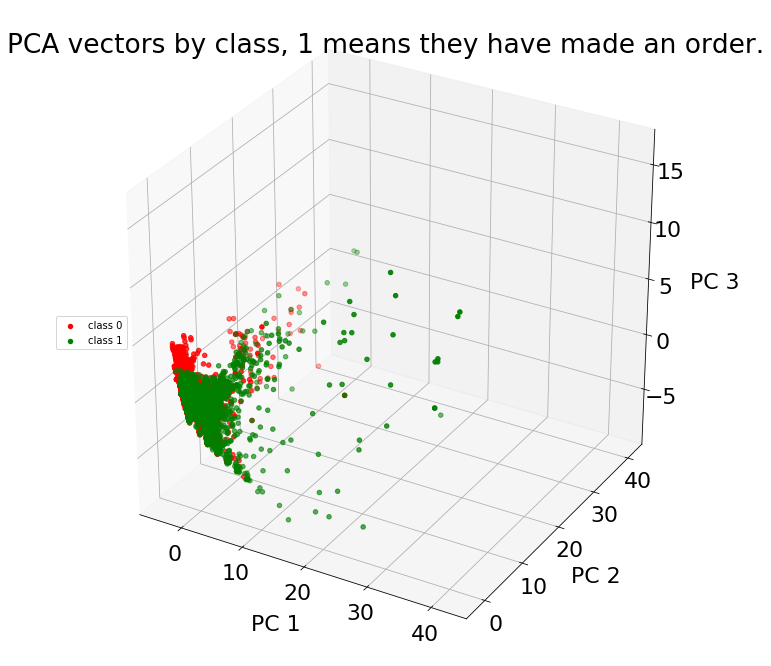

In [33]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
targets = [0, 1]
colors = ['r', 'g']

for target, color in zip(targets,colors):
    indicesToKeep = PCA_plot['order_prod'] == target
    ax.scatter(PCA_plot.loc[indicesToKeep, 'PC 1']
               , PCA_plot.loc[indicesToKeep, 'PC 2']
               , PCA_plot.loc[indicesToKeep, 'PC 3']
               , "o"
               , c = color
               , label = "class " + str(target))

# ax.plot(finalDf["PC 1"], finalDf["PC 2"], finalDf["PC 3"], 'o', markersize=8, color='blue', alpha=0.5, label='class1')

ax.set_xlabel("PC 1", labelpad=20)
ax.set_ylabel("PC 2", labelpad=20)
ax.set_zlabel("PC 3", labelpad=25)

ax.yaxis._axinfo['label']['space_factor'] = -100.0

plt.title('PCA vectors by class, 1 means they have made an order.')
ax.legend(loc='center left', prop={'size': 10})
plt.show()

Since the last principal component do not explain much of the variance, we will plot the explained variance for all the variables and see how many features needed to explain 95% of the variance

In [34]:
pca = PCA(n_components=len(X_scaled.T))
X_pca = pca.fit_transform(X_scaled)

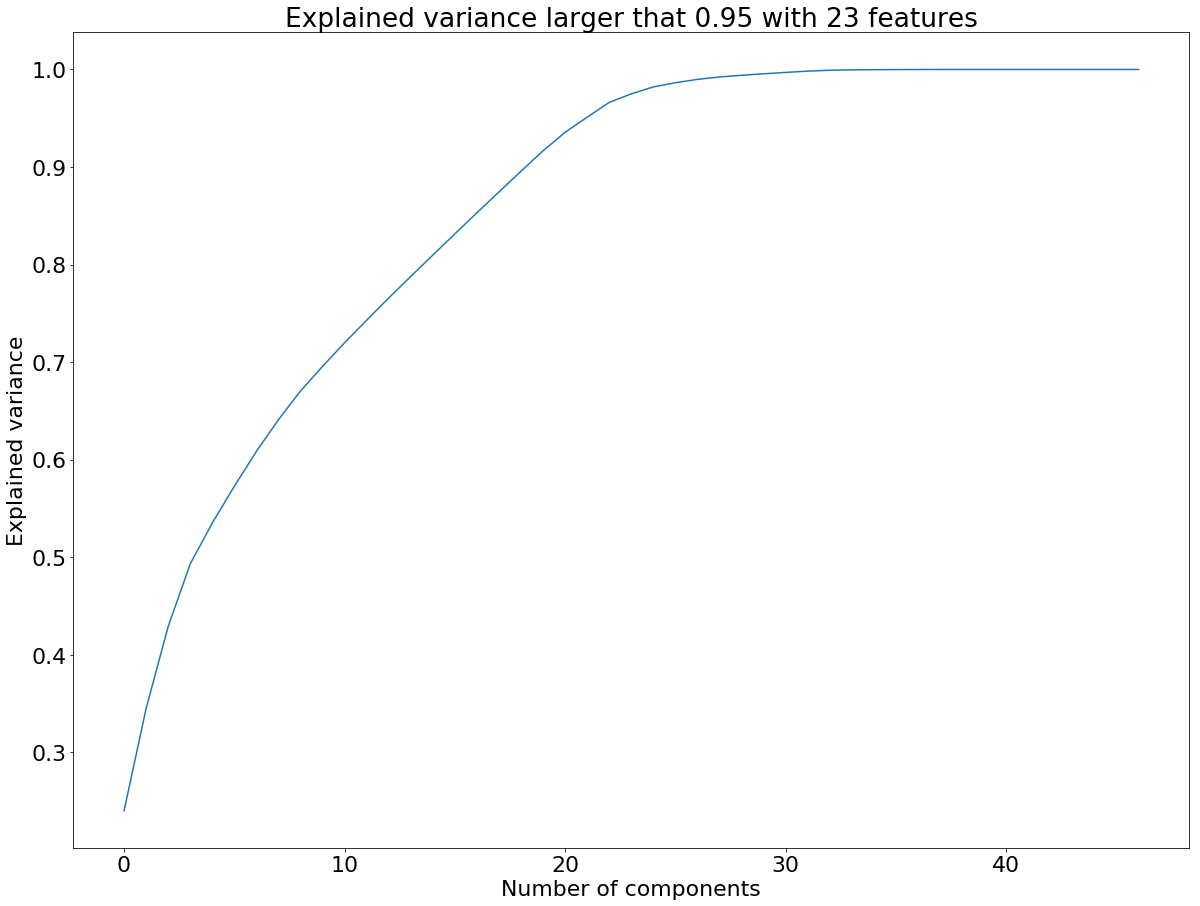

In [35]:
i = 0
cum_var = 0
for var in range(len(pca.explained_variance_ratio_)):
    if cum_var<0.95:
        i += 1
        cum_var = cum_var + pca.explained_variance_ratio_[var]
    else:
        i += 1
        break

plt.plot(np.cumsum((pca.explained_variance_ratio_)))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.title("Explained variance larger that 0.95 with " + str(i) + " features")
size
font
plt.show()

We see at 23 components, we explain about 95% of the variation. We make a dataset for this for later use

In [36]:
pca = PCA(n_components=23)
X_pca = pca.fit_transform(X)
PCA_DF = pd.DataFrame(data = X_pca)

## We now see if can make some sensible clusters to use in our futher

In [37]:
# First, reload data to make sure it is clean.
X = data_base.iloc[:, col_of_pred :]
X_scaled= StandardScaler().fit_transform(X)
y = data_base.loc[:, 'tot_inv']

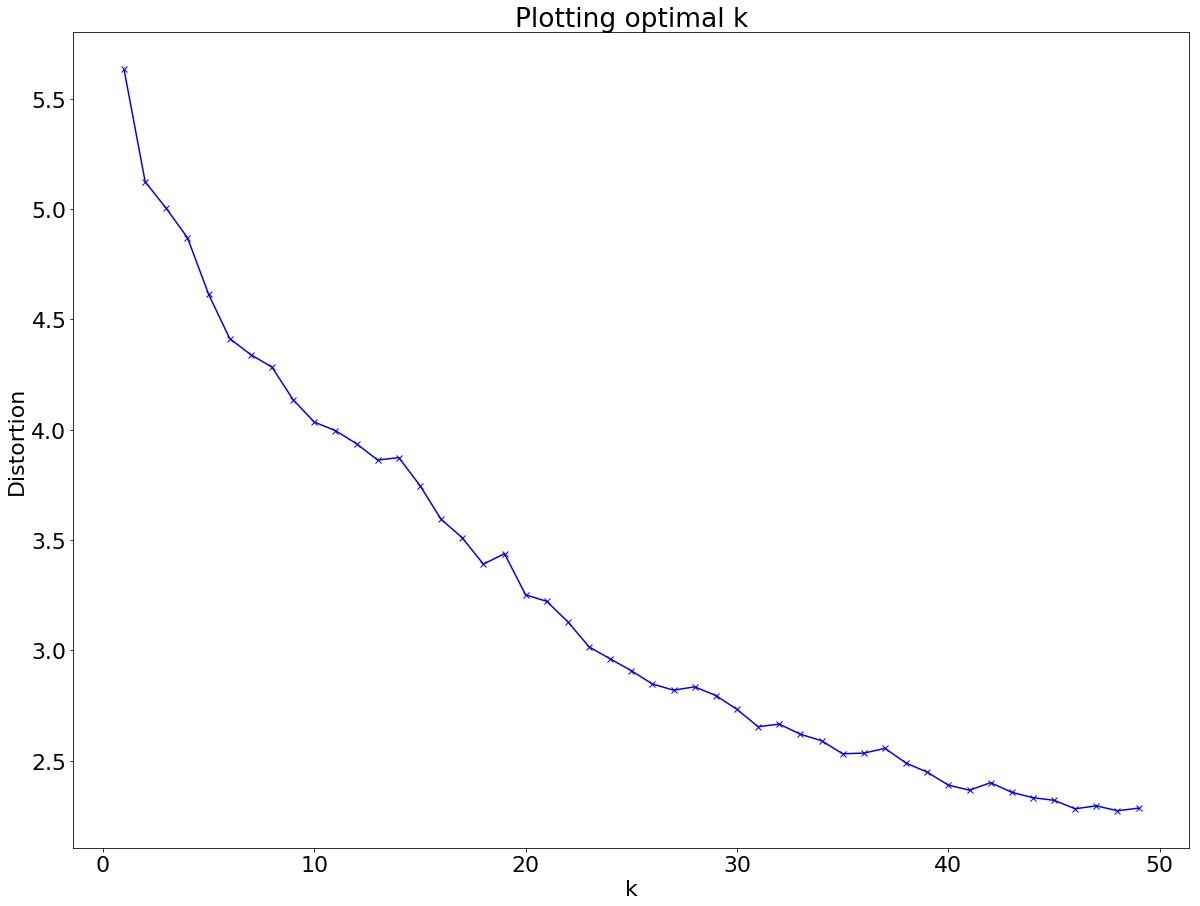

In [38]:
distortions = []
K = range(1, 50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    distortions.append(sum(np.min(cdist(X_scaled, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_scaled.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Plotting optimal k')
size
font
plt.show()

There is no clear elbow, but we do not want to have too many clusters either. 13 Clusters seems to be a nice starting point.

In [39]:
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(X_scaled)

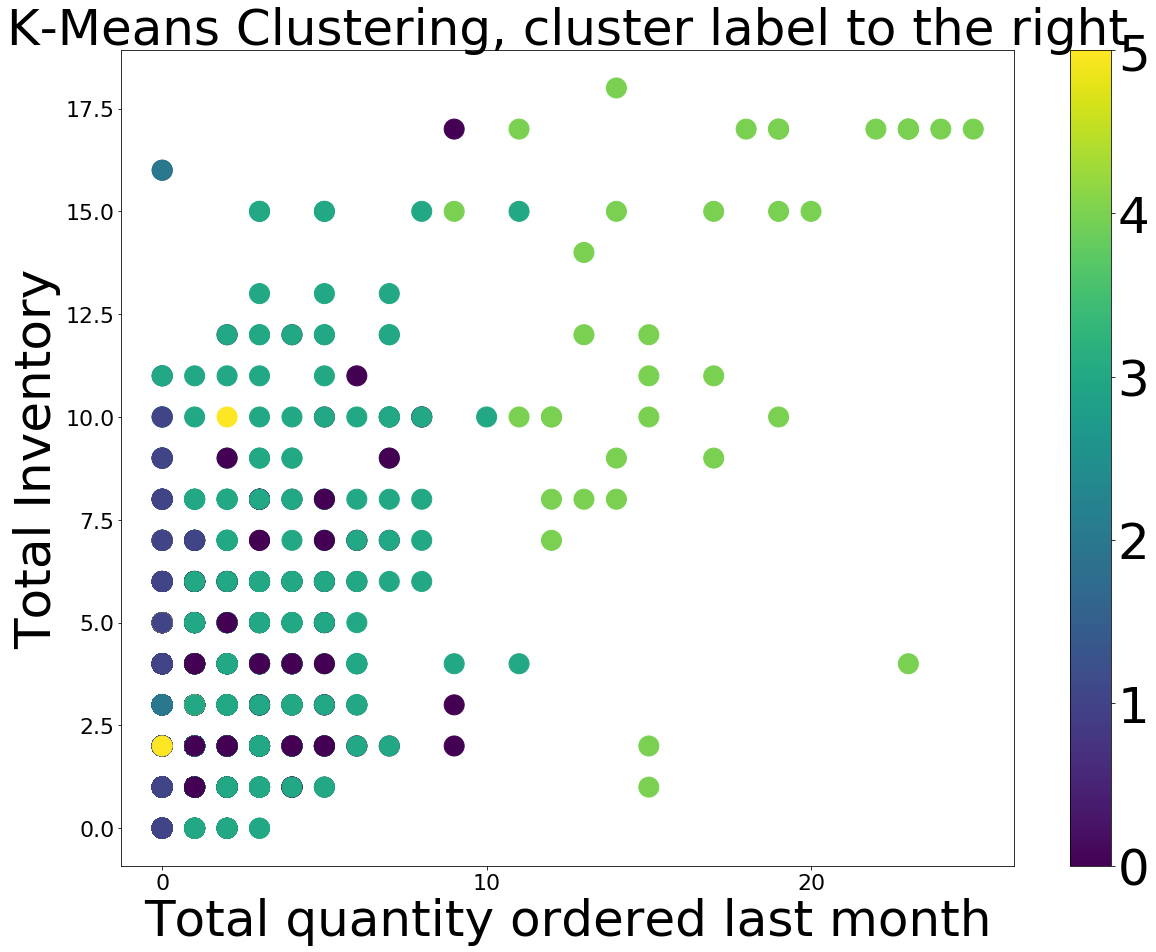

In [40]:
fontsize = fontdict={'fontsize': 50}
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(X.loc[:, 'l_tot_qty'],y,
                     c=clusters, s=400)
ax.set_title('K-Means Clustering, cluster label to the right', fontdict=fontsize)
ax.set_xlabel('Total quantity ordered last month', fontdict=fontsize)
ax.set_ylabel('Total Inventory', fontdict=fontsize)
plt.rc('ytick', labelsize=50)
plt.rc('xtick', labelsize=50)
plt.colorbar(scatter)
plt.show()

We see that we do get some type of output from the clustering, but not too distinct groups and a lot of overlap.

## We first want to try to predict if they will make an order next month
We remove some of the columns from the data set, as they are highly correlated, and dropping them gives more accurate results. We then split the data set into development and testing data

In [389]:
X = data_base.iloc[:, col_of_pred :]
y = data_base["order_prod"]

# We drop some variables due to high correlation
#X = X.drop(["l_tot_value", "l_qty_prod1", "l_qty_prod2", "l_tot_inv_dollars", "l_inv_prod2", "l_inv_prod1"
            #, "l_return_qty1", "l_return_qty2", "l_return_tot_value", "l_numb_returns1", "l_numb_returns2"
            #, "l_fcons_qty_prod1", "l_fcons_qty_prod2", "l_fcons_tot_value", "l_shipment", "l_sale"], axis=1)
           
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Make clusters based on previous analysis

In [390]:
X_dev, X_test = my_cluster(X_dev, X_test)

### Make a decision tree using cross validation

In [172]:
# Number of branches
branch_length = range(1, 21)

# List for index
branches = list(branch_length)

# Number of validations
kfolds = KFold(n_splits = 10)

# Make list for the accuracy for all runs, and the mean accuracy for a tree
accuracy = []
tree_accuracy = []
trainAUC_DTree = []
testAUC_DTree = []

for depth in branch_length:
    _accuracy = []
    _train = []
    _test = []
    
    # Define tree
    DTree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    
    # Create validation set
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        
        # Fit and predict training data
        DTree = DTree.fit(X_train, y_train)
        train_pred = DTree.predict(X_train)
        
        # Create ROC for training data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, DTree.predict_proba(X_train)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _train.append(roc_auc)
        
        # Predict test data
        y_pred = DTree.predict(X_val)
        
        # Create ROC for test data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, DTree.predict_proba(X_val)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _test.append(roc_auc)
        
        # Append accuracy score
        _accuracy.append(metrics.accuracy_score(y_val, y_pred))
        
    trainAUC_DTree.append(np.mean(_train))
    testAUC_DTree.append(np.mean(_test))
    
    accuracy.append(_accuracy)
    tree_accuracy.append(np.mean(accuracy[depth-1]))
    
df_test_result = pd.DataFrame(testAUC_DTree, index=branches).mean(axis=1)
optimal_branches = df_test_result[df_test_result==max(df_test_result)].index[0]
print("Optimal branches at: " + str(optimal_branches) + " branches.")
print("With max area of : " + str(max(df_test_result)) + ".")

Optimal branches at: 5 branches.
With max area of : 0.8409042423914064.


Plot the results from the decision tree

In [174]:
# Reset graph settings
plt.rcdefaults()

In [175]:
size = plt.rcParams["figure.figsize"] = [20, 15]
font = plt.rcParams.update({'font.size': 22})

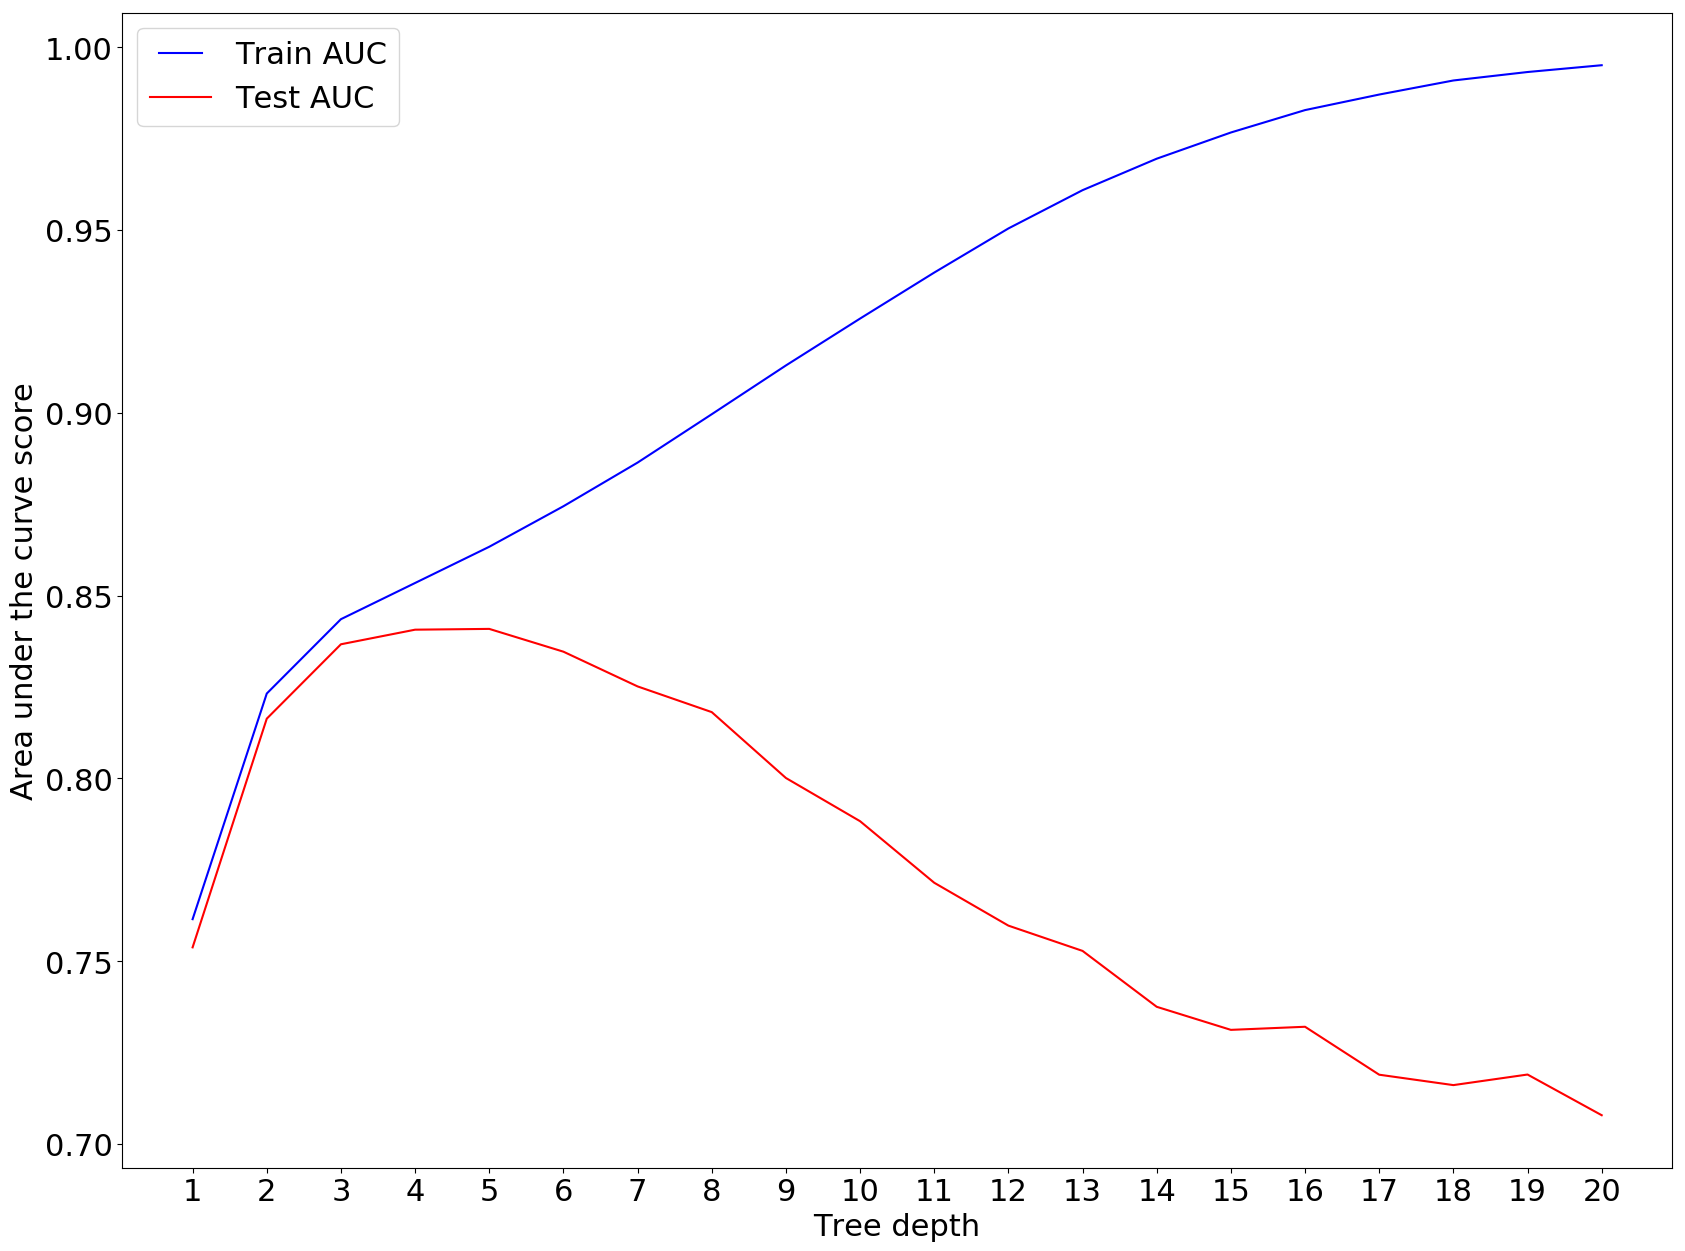

In [176]:
train_test_AUC(branch_length, trainAUC_DTree, testAUC_DTree, local_label='Tree depth')

We now check if we get similar results using PCA

In [177]:
PCA_dev, PCA_test, y_dev, y_test = train_test_split(PCA_DF, y, test_size=0.2, random_state=1)

In [178]:
# Fit clusters on development, and apply to both development and test
kmeans = KMeans(n_clusters=6)
kmeans.fit(PCA_dev)
dev_cluster = kmeans.predict(PCA_dev)
test_cluster = kmeans.predict(PCA_test)

# Merge these back to the development and test data
PCA_dev = PCA_dev.assign(cluster = dev_cluster)
PCA_test = PCA_test.assign(cluster = test_cluster)

In [179]:
# Number of branches
branch_length = range(1, 21)

# List for index
branches = list(branch_length)

# Number of validations
kfolds = KFold(n_splits = 10)

# Make list for the accuracy for all runs, and the mean accuracy for a tree
accuracy = []
tree_accuracy = []
trainAUC_DTree_PCA = []
testAUC_DTree_PCA = []

for depth in branch_length:
    _accuracy = []
    _train = []
    _test = []
    
    # Define tree
    DTree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    
    # Create validation set
    for train_idx, val_idx in kfolds.split(PCA_dev, y_dev):
        X_train, y_train = PCA_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = PCA_dev.iloc[val_idx], y_dev.iloc[val_idx]
        
        # Fit and predict training data
        DTree = DTree.fit(X_train,y_train)
        train_pred = DTree.predict(X_train)
        
        # Create ROC for training data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, DTree.predict_proba(X_train)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _train.append(roc_auc)
        
        # Predict test data
        y_pred = DTree.predict(X_val)
        
        # Create ROC for test data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, DTree.predict_proba(X_val)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _test.append(roc_auc)
        
        # Append accuracy score
        _accuracy.append(metrics.accuracy_score(y_val, y_pred))
        
    trainAUC_DTree_PCA.append(np.mean(_train))
    testAUC_DTree_PCA.append(np.mean(_test))
    
    accuracy.append(_accuracy)
    tree_accuracy.append(np.mean(accuracy[depth-1]))
    
df_test_result = pd.DataFrame(testAUC_DTree_PCA, index=branches).mean(axis=1)
optimal_branches = df_test_result[df_test_result==max(df_test_result)].index[0]
print("Optimal branches at: " + str(optimal_branches) + " branches.")
print("With max area of : " + str(max(df_test_result)) + ".")

Optimal branches at: 6 branches.
With max area of : 0.781055675954424.


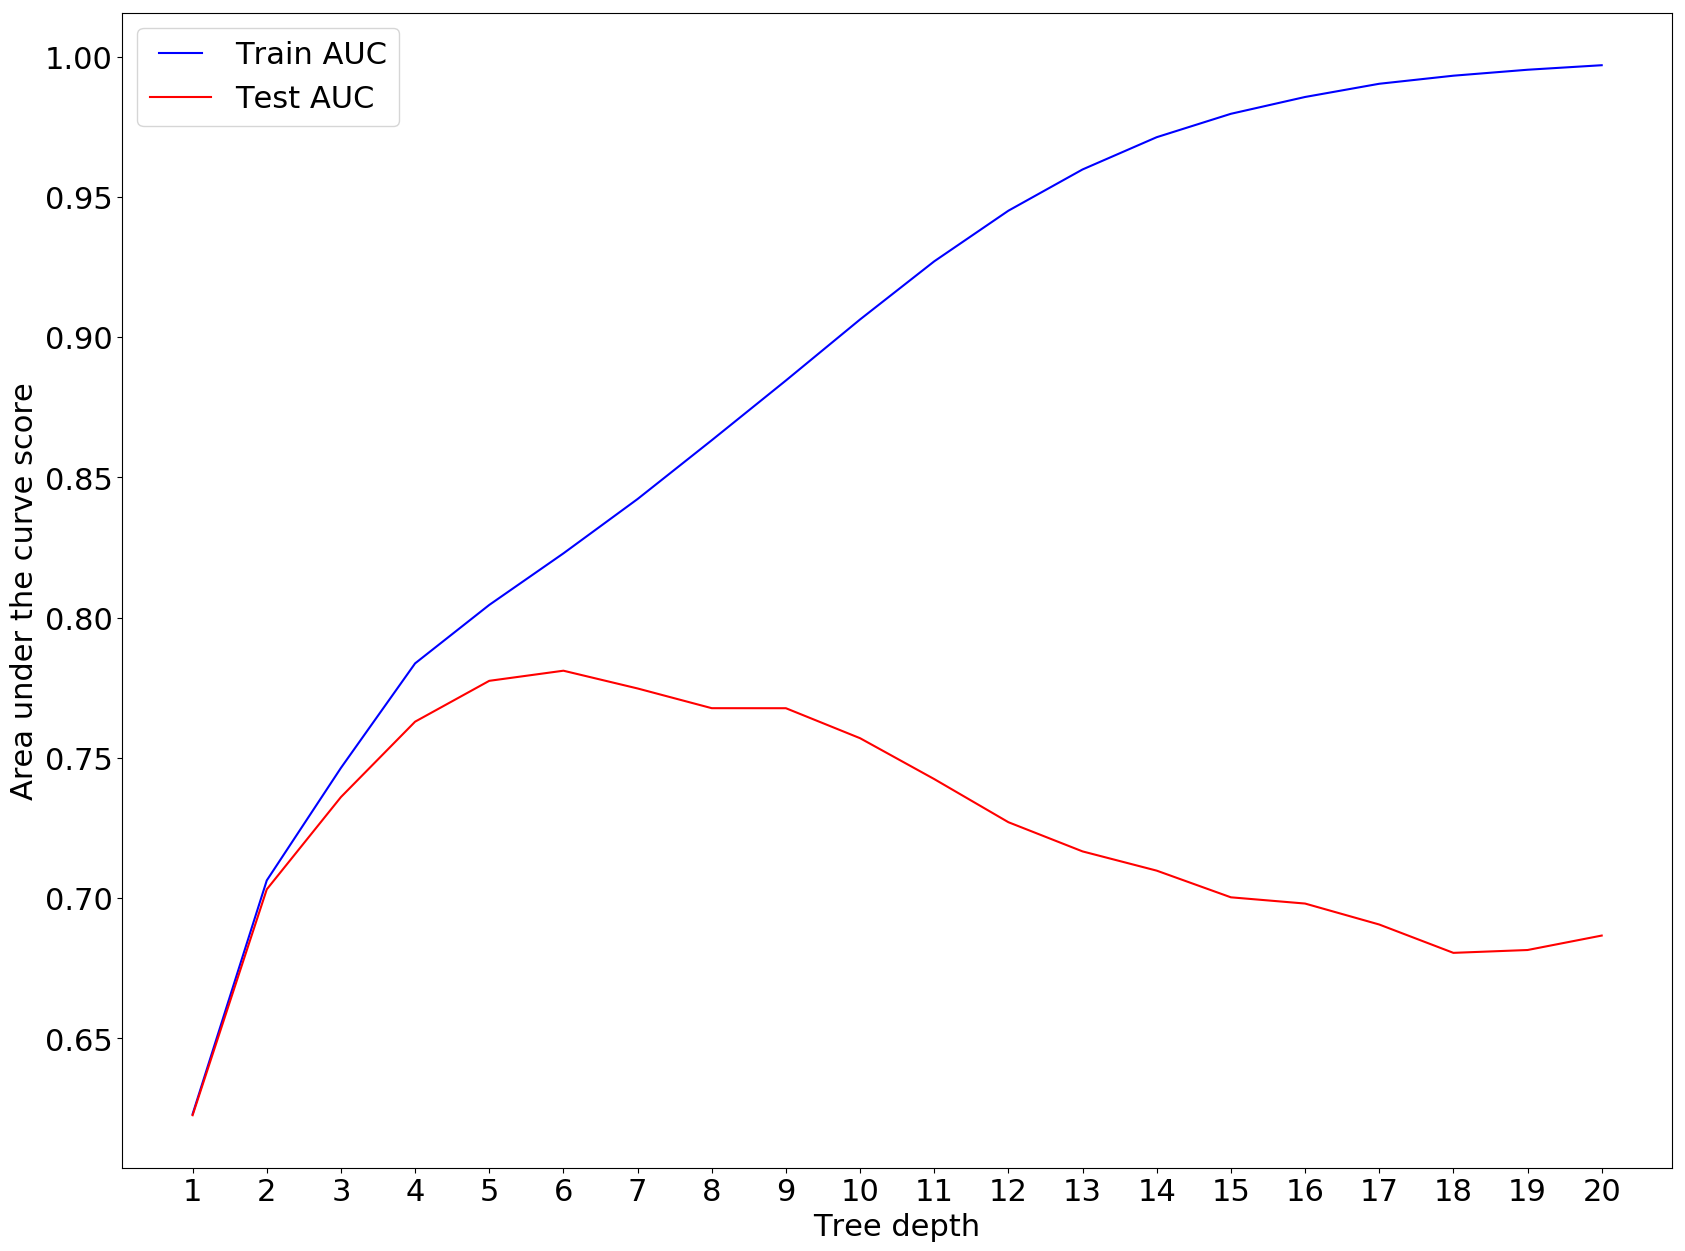

In [180]:
train_test_AUC(branch_length, trainAUC_DTree_PCA, testAUC_DTree_PCA, local_label='Tree depth')

We use the optimal number of branches and find max number of features to include

In [181]:
# Number of branches
feature_lenght = range(1, len(X.columns))

# List for index
features = list(feature_lenght)

# Number of validations
kfolds = KFold(n_splits = 10)

# Make list for the accuracy for all runs, and the mean accuracy for a tree
accuracy = []
tree_accuracy = []
train_result = []
test_result = []

for feat in feature_lenght:
    _accuracy = []
    _train = []
    _test = []
    
    # Define tree
    DTree = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_branches, max_features=feat)
    
    # Create validation set
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        
        # Fit and predict training data
        DTree = DTree.fit(X_train,y_train)
        train_pred = DTree.predict(X_train)
        
        # Create ROC for training data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, DTree.predict_proba(X_train)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _train.append(roc_auc)
        
        # Predict test data
        y_pred = DTree.predict(X_val)
        
        # Create ROC for test data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, DTree.predict_proba(X_val)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _test.append(roc_auc)
        
        # Append accuracy score
        _accuracy.append(metrics.accuracy_score(y_val, y_pred))
        
    train_result.append(np.mean(_train))
    test_result.append(np.mean(_test))
    
    accuracy.append(_accuracy)
    tree_accuracy.append(np.mean(accuracy[feat-1]))
    
df_test_result = pd.DataFrame(test_result, index=features).mean(axis=1)
optimal_features = df_test_result[df_test_result==max(df_test_result)].index[0]
print("Optimal features at: " + str(optimal_features) + " features.")
print("With max area of : " + str(max(df_test_result)) + ".")

Optimal features at: 31 features.
With max area of : 0.8417432082749482.


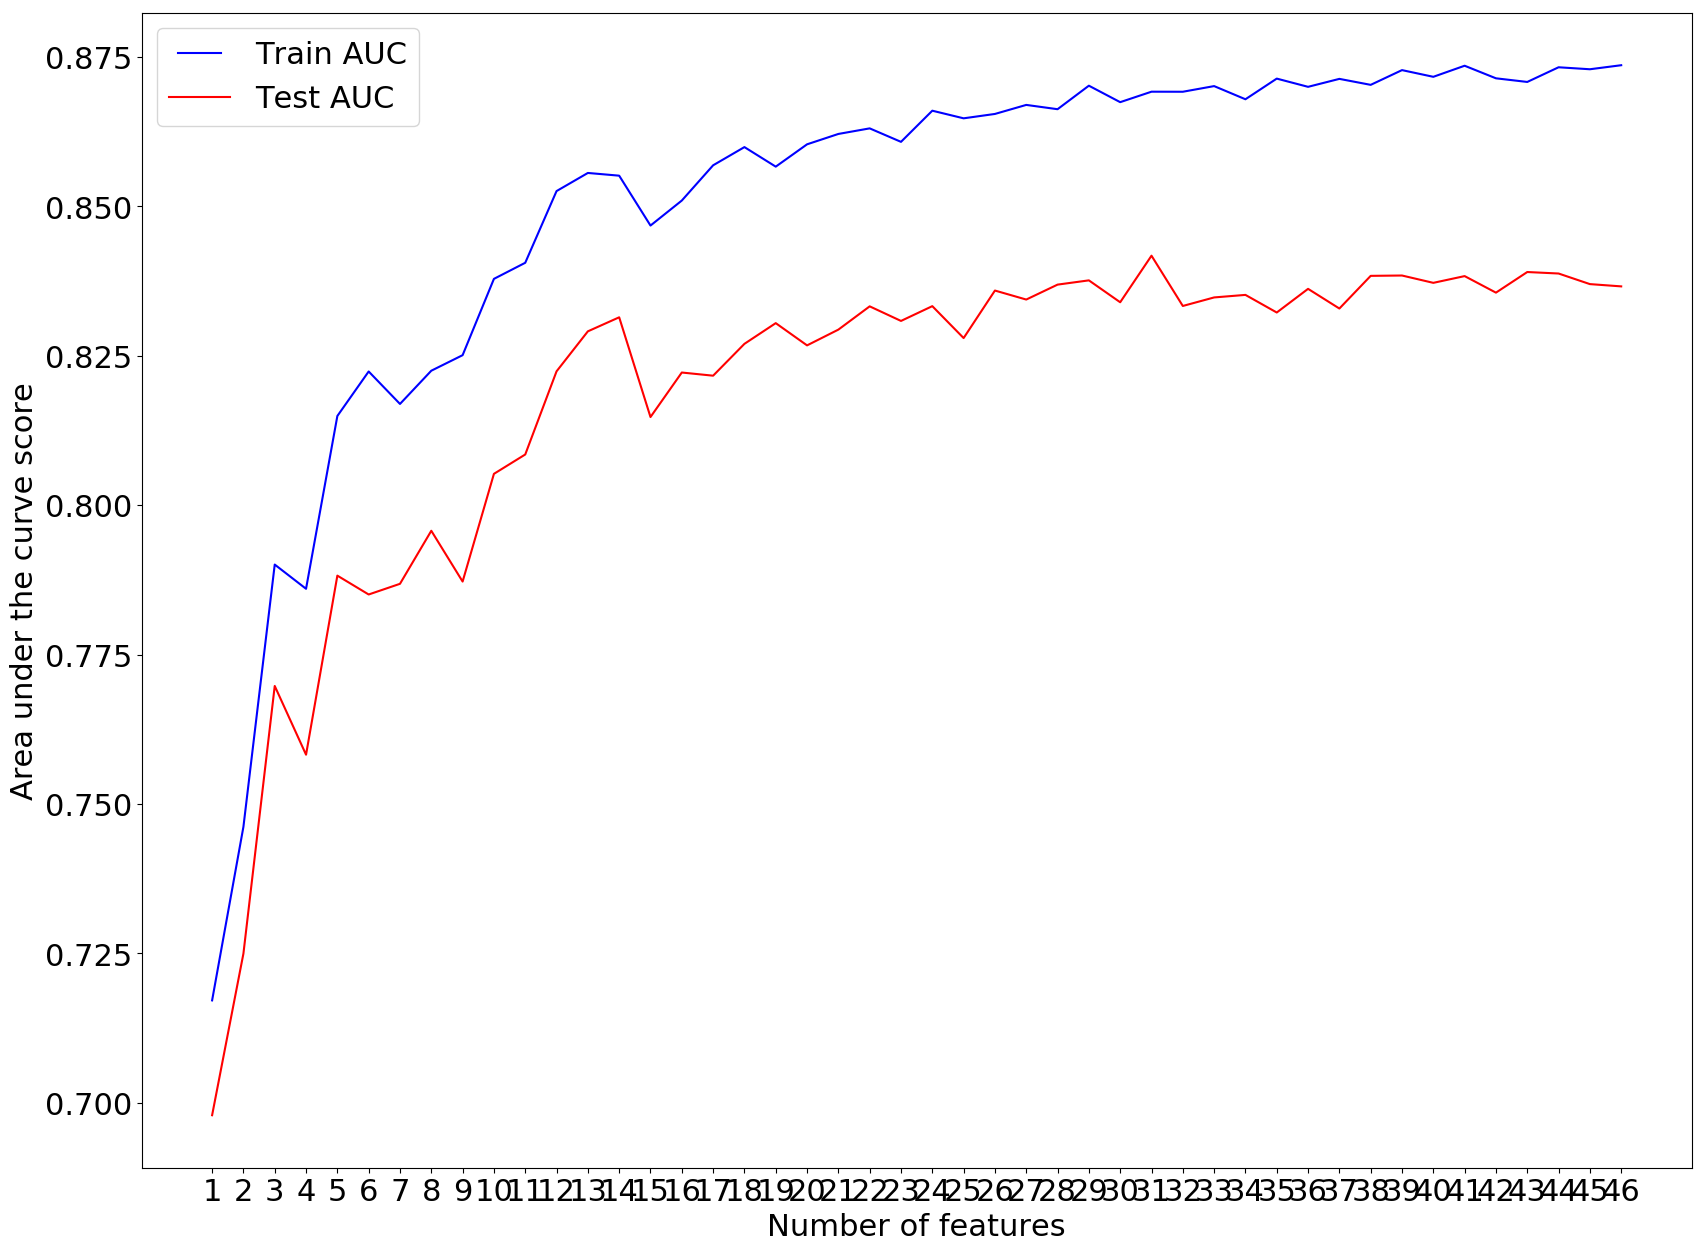

In [182]:
train_test_AUC(feature_lenght, train_result, test_result, local_label='Number of features')

With optimal number of branches and featues, we use all of the training data

In [398]:
DTree = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_branches, max_features=optimal_features)
DTree_nonPCA = DTree.fit(X_dev, y_dev)
y_pred = DTree_nonPCA.predict(X_test)

This is our best prediction of orders next month, we take this out to its own table

In [184]:
# Predict again, and put the true values to merge on the predictions
DTree_prob = pd.DataFrame(DTree_nonPCA.predict_proba(X_test)[:, 1], columns=['probability'])
y_test_export = y_test.reset_index(drop=True)
y_pred_export = pd.DataFrame(y_pred)

In [185]:
# We might want the customer labels?
#customer_labels = data_base.iloc[:, :3]

In [186]:
#test =customer_labels.merge(y_test, how='right', left_index=True, right_index=True)

In [187]:
DTree_order_prod_export = DTree_prob.assign(true = y_test_export, predicted = y_pred_export).sort_values(by=['probability'], ascending=False)

In [189]:
DTree_order_prod_export.to_csv('order_prod_prediction.csv')

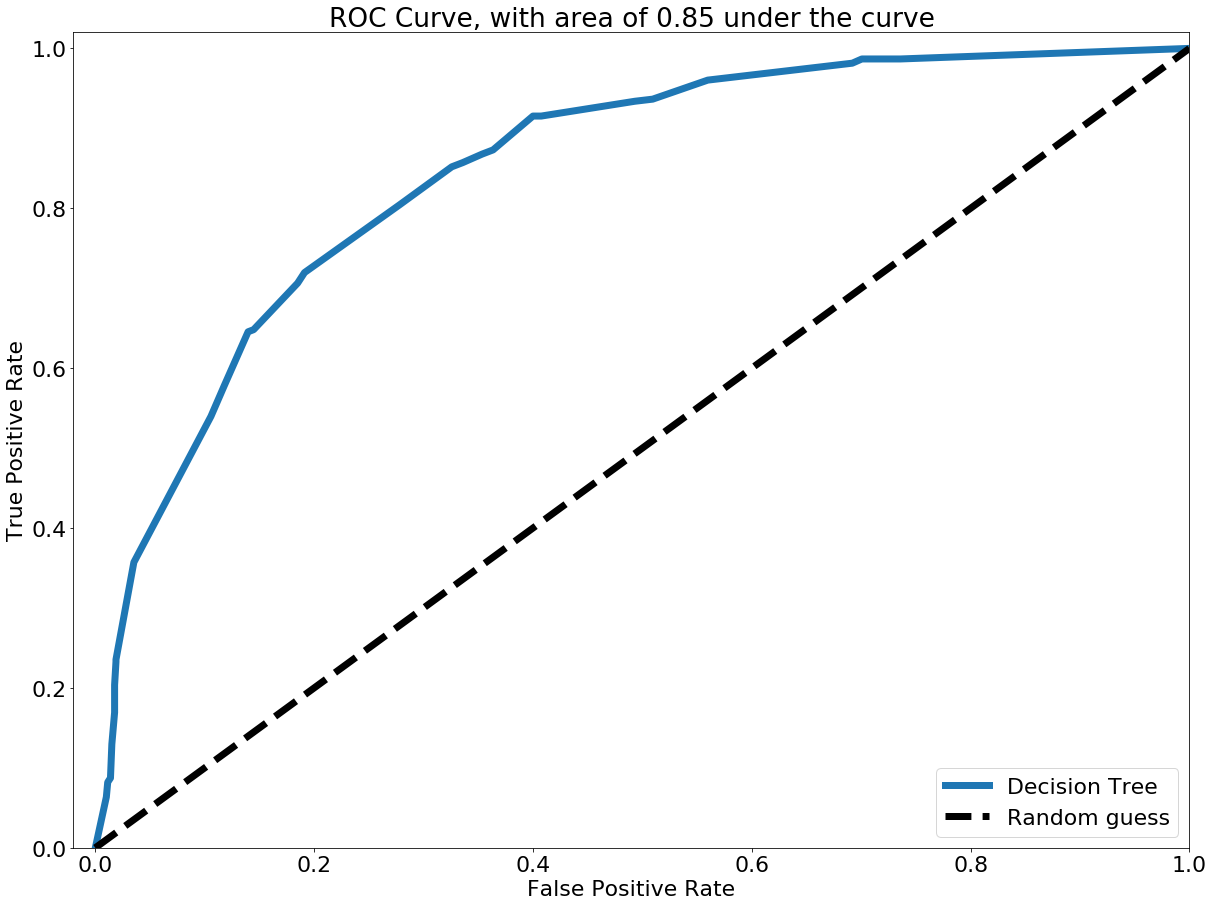

In [399]:
ROC(X_test, y_test, DTree_nonPCA, plot_label='Decision Tree')

In [105]:
DTree = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_branches)
DTree_PCA = DTree.fit(PCA_dev, y_dev)
y_pred = DTree_PCA.predict(PCA_test)

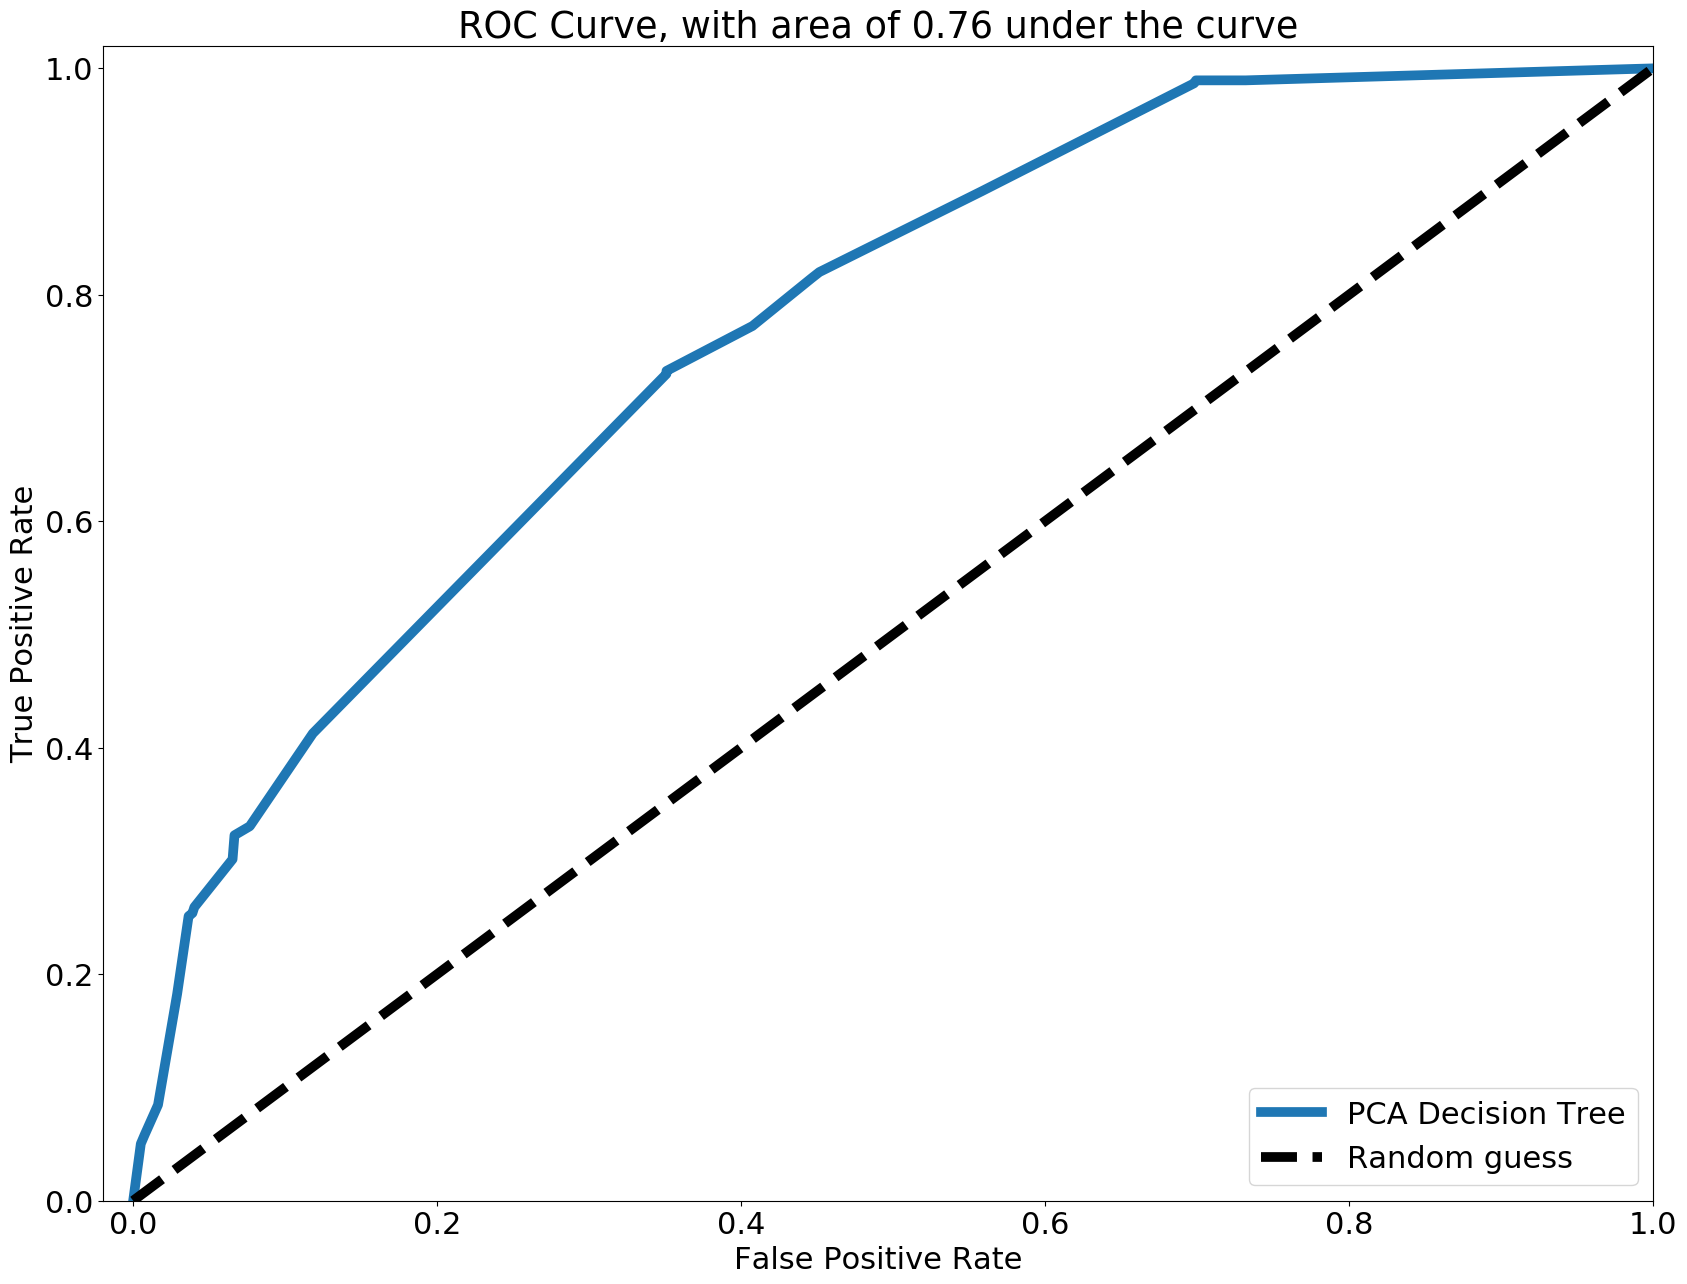

In [106]:
ROC(PCA_test, y_test, DTree_PCA, plot_label='PCA Decision Tree')

Using the PCA gives a worse performance, we now keep the tree without PCA and print the decision tree.

In [62]:
DTree = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_branches, max_features=optimal_features)

DTree = DTree.fit(X_dev, y_dev)
y_pred = DTree.predict(X_test)
DTree_prob = DTree.predict_proba(X_test)[:, 1]

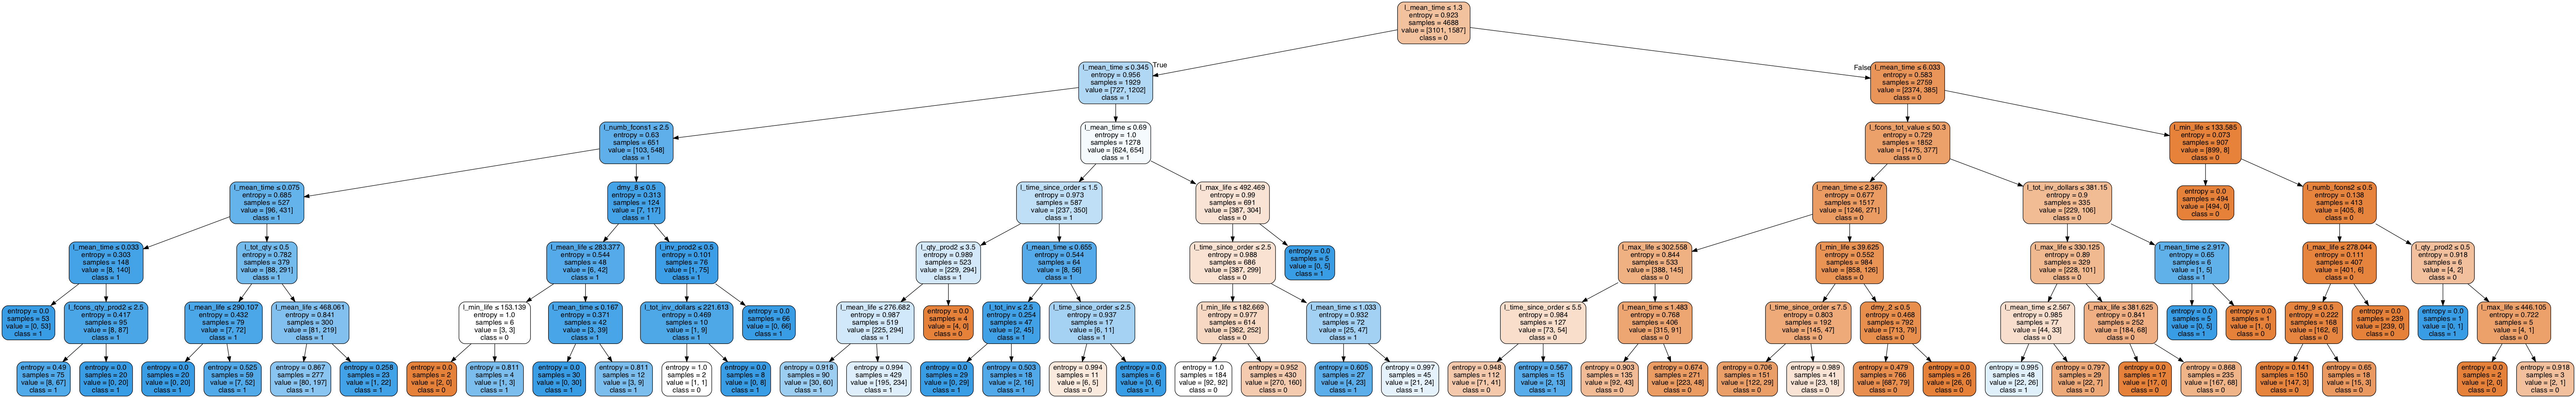

In [63]:
dot_data = StringIO()
export_graphviz(DTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns, class_names=['0', '1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('inventory.png')
Image(graph.create_png())

# Now we do some regressions
### We would like to first see if we can predict how much our customers will order next month.

In [64]:
X = data_base.iloc[:, col_of_pred :]
y = data_base.loc[:, "tot_inv"]

In [65]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [66]:
X_dev, X_test = my_cluster(X_dev, X_test)

In [67]:
# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(X_dev, y_dev)
# Predict
y_predicted = regression_model.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Intercept: -315538.9652325228
Root mean squared error:  0.5831096882661931
R2 score:  0.8196227762992666


We make quite good predictions with the linear regression on total inventory next month. Do we over predict, or under predict?

In [68]:
print("Actual invenotry is: " + str(np.sum(y_test)))
print("Predicted inventory is: " + str(np.sum(y_predicted)))

Actual invenotry is: 2430
Predicted inventory is: 2419.5213801341015


In [69]:
coeff_df = pd.DataFrame(regression_model.coef_, X_dev.columns, columns=['Coefficient'])  

In [70]:
f = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})

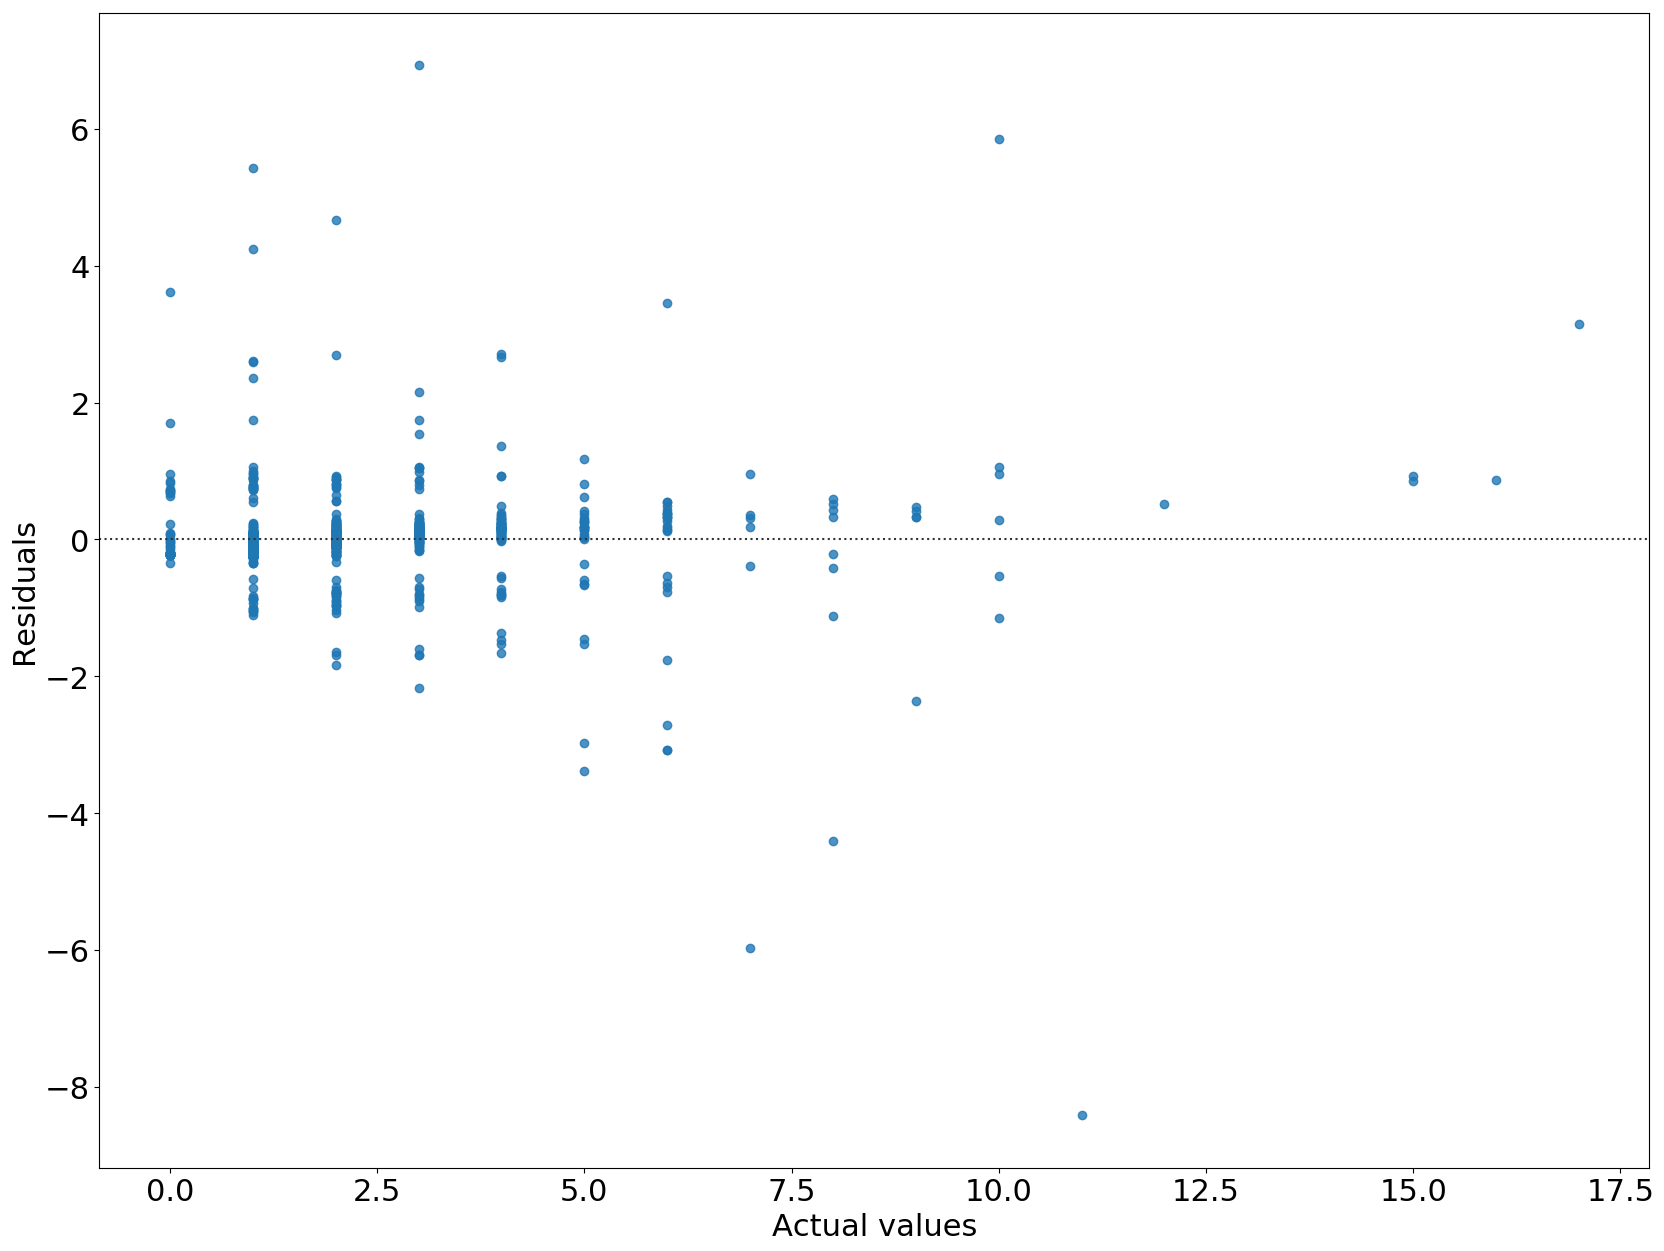

In [71]:
ax = sns.residplot(y_test, y_predicted)
ax.set(xlabel='Actual values', ylabel='Residuals')
plt.show()

### We then try to regress total quantity ordered next month

In [449]:
X = data_base.iloc[:, col_of_pred :]
y = data_base.loc[:, "tot_qty"]
# We remove some variables as there might be high correlation
# X = X.drop(to_drop, axis=1)

In [450]:
# X = X.merge(np.power(X.iloc[:, :-13], 2), how='inner', left_index=True, right_index=True)

In [451]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [470]:
X_dev, X_test = my_cluster(X_dev, X_test)

In [471]:
# Model initialization
reg = LinearRegression()
# Fit the data(train the model)
reg.fit(X_dev, y_dev)
# Predict
y_predicted = reg.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
print('Intercept:', reg.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Intercept: -0.2044570291213753
Root mean squared error:  0.9653159915661106
R2 score:  0.40247759325859755


This is not a good prediction. We can try to remove the worst performing variables

In [472]:
# We can use one of SKLEARN modules to remove the worst performing variables
# This is using cross validation
reg_RFE = RFECV(estimator=reg, step=1, scoring='r2', cv=10)
reg_RFE.fit(X_dev, y_dev)
print("Optimal number of features: " + str(reg_RFE.n_features_))

Optimal number of features: 44


In [499]:
rfe = RFE(reg, reg_RFE.n_features_)
rfe = rfe.fit(X_dev, y_dev)
y_predicted = rfe.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)


#print('Slope:' ,regression_model.coef_)
print('Intercept:', rfe.estimator_.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Intercept: 18728959.893259913
Root mean squared error:  0.9479664798246756
R2 score:  0.4132167937920018


We are unable to make any better prediction, note that I have also tried to remove highly correlated variables, without any better prediction.

So our prediction of quantity of orders are worse, but again, do we over or under predict? What is the overall accuracy?

In [500]:
print("Actual orders are: " + str(np.sum(y_test)))
print("Predicted orders are: " + str(np.sum(y_predicted)))
print("So overall accuracy in ordering is " + str(np.sum(y_predicted)/np.sum(y_test)))

Actual orders are: 672
Predicted orders are: 697.8090545646846
So overall accuracy in ordering is 1.0384063311974474


So we predict 3% more orders than was actually made, which aggregated is not too bad.

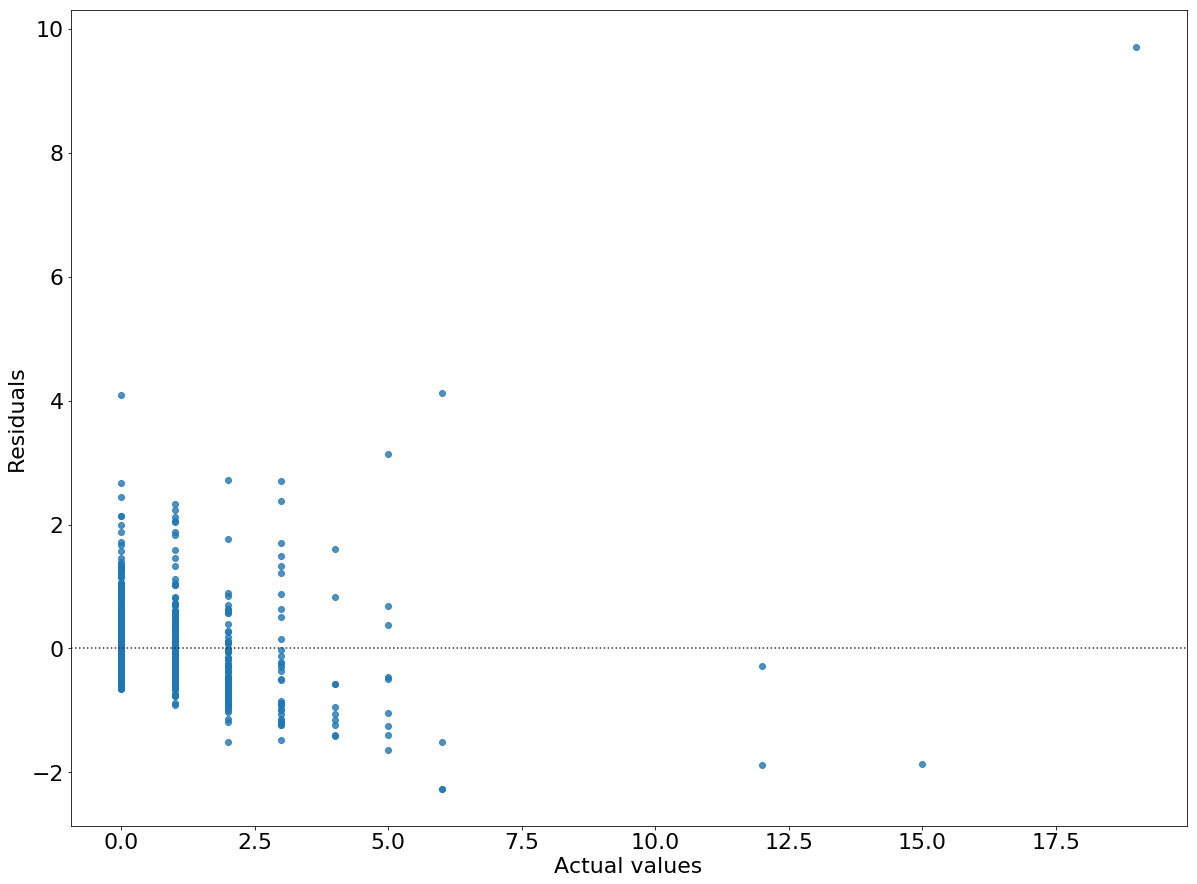

In [479]:
ax = sns.residplot(y_test, y_predicted)
ax.set(xlabel='Actual values', ylabel='Residuals')
plt.show()

There are some outliers, we try to drop if they order more than 10 quantities.

In [489]:
y_test[y_test>10].index

Int64Index([3274, 3272, 1586, 5047], dtype='int64')

In [503]:
y_dev_clean = y_dev.drop(y_dev[y_dev>10].index)
X_dev_clean = X_dev.drop(y_dev[y_dev>10].index)
y_test_clean = y_test.drop(y_test[y_test>10].index)
X_test_clean = X_test.drop(y_test[y_test>10].index)

In [504]:
y_predicted = reg.predict(X_test_clean)

# model evaluation
rmse = mean_squared_error(y_test_clean, y_predicted)
r2 = r2_score(y_test_clean, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
print('Intercept:', reg.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Intercept: 0.3306253495941996
Root mean squared error:  0.7261589888387613
R2 score:  0.21654314564731703


Removing the outliers, does not help. Note: I have also tries to fit the model again, but did not change the result.

Predicting total quantity is harder, we get a lower prediction accuracy, and the residual plot is quite bad.

Lets split out the hospitals that never make an order, to see if we get a better prediction:

In [556]:
grouped = data_base.groupby(by='soldtocust').sum()

drop_customers = grouped.drop(grouped[grouped['tot_qty']==0].index)

cleaned_data_base = data_base[data_base['soldtocust'].isin(list(drop_customers.index))]

X = cleaned_data_base.iloc[:, col_of_pred :]
y = cleaned_data_base.loc[:, 'tot_qty']

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_dev, X_test = my_cluster(X_dev, X_test)

# Model initialization
reg = LinearRegression()
# Fit the data(train the model)
reg.fit(X_dev, y_dev)
# Predict
y_predicted = reg.predict(X_test)

# model evaluation
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
print('Intercept:', reg.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

Intercept: -0.10537477916303406
Root mean squared error:  1.5318245495109801
R2 score:  0.3626556750901334


## We then do logit regressions

In [277]:
y = data_base.loc[:, "order_prod"]
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [78]:
X_dev, X_test = my_cluster(X_dev, X_test)

In [79]:
logreg = LogisticRegression()
logreg.fit(X_dev, y_dev)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [80]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression: ' + str(logreg.score(X_test, y_test)))

Accuracy of logistic regression: 0.7348678601875532


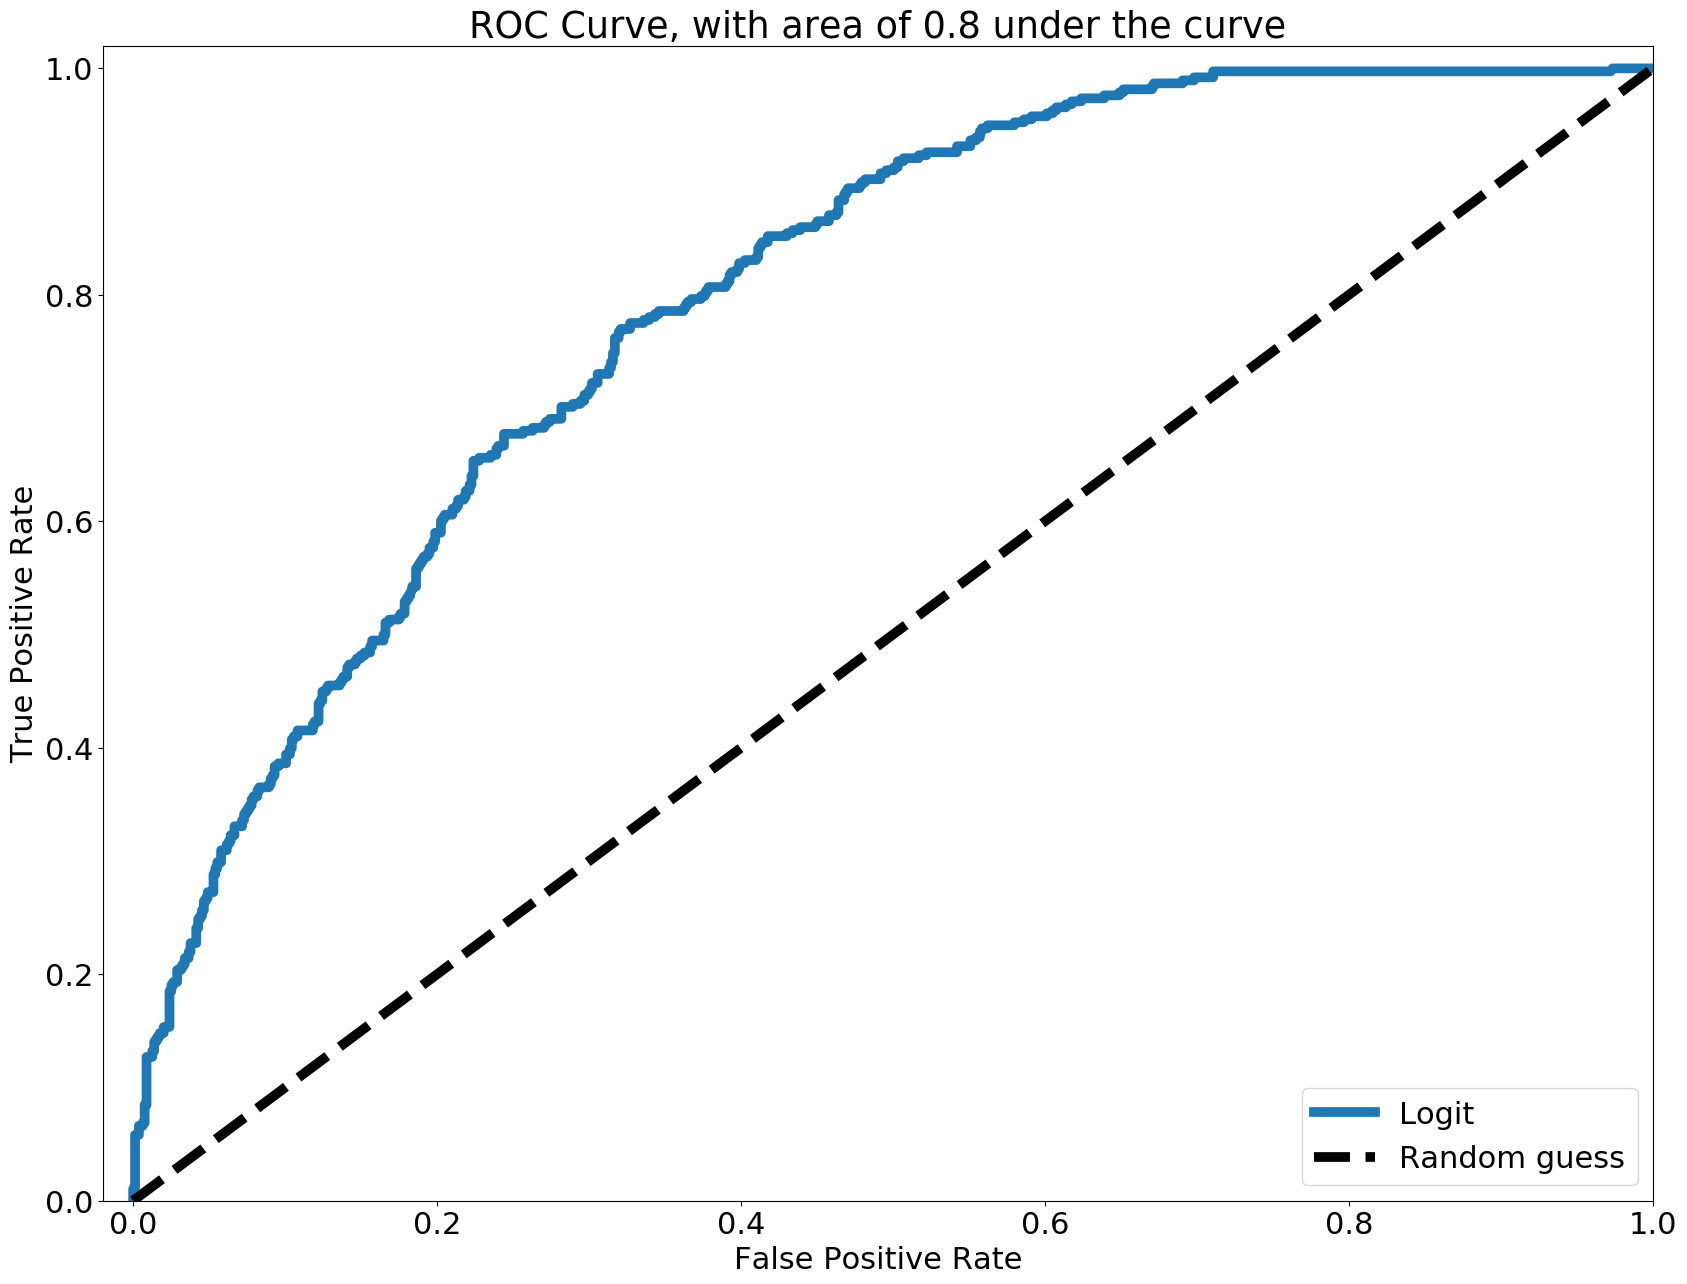

In [81]:
ROC(xtest=X_test, ytest=y_test, fitter=logreg, plot_label='Logit')

# We then go on to do Naive Bayes and KNN

In [82]:
y = data_base.loc[:, "order_prod"]
X = data_base.iloc[:, col_of_pred :]

In [83]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_dev, X_test = my_cluster(X_dev, X_test)

In [84]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_dev, y_dev)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [85]:
print("Accuracy:", metrics.accuracy_score(y_test, gnb.predict(X_test)))

Accuracy: 0.7007672634271099


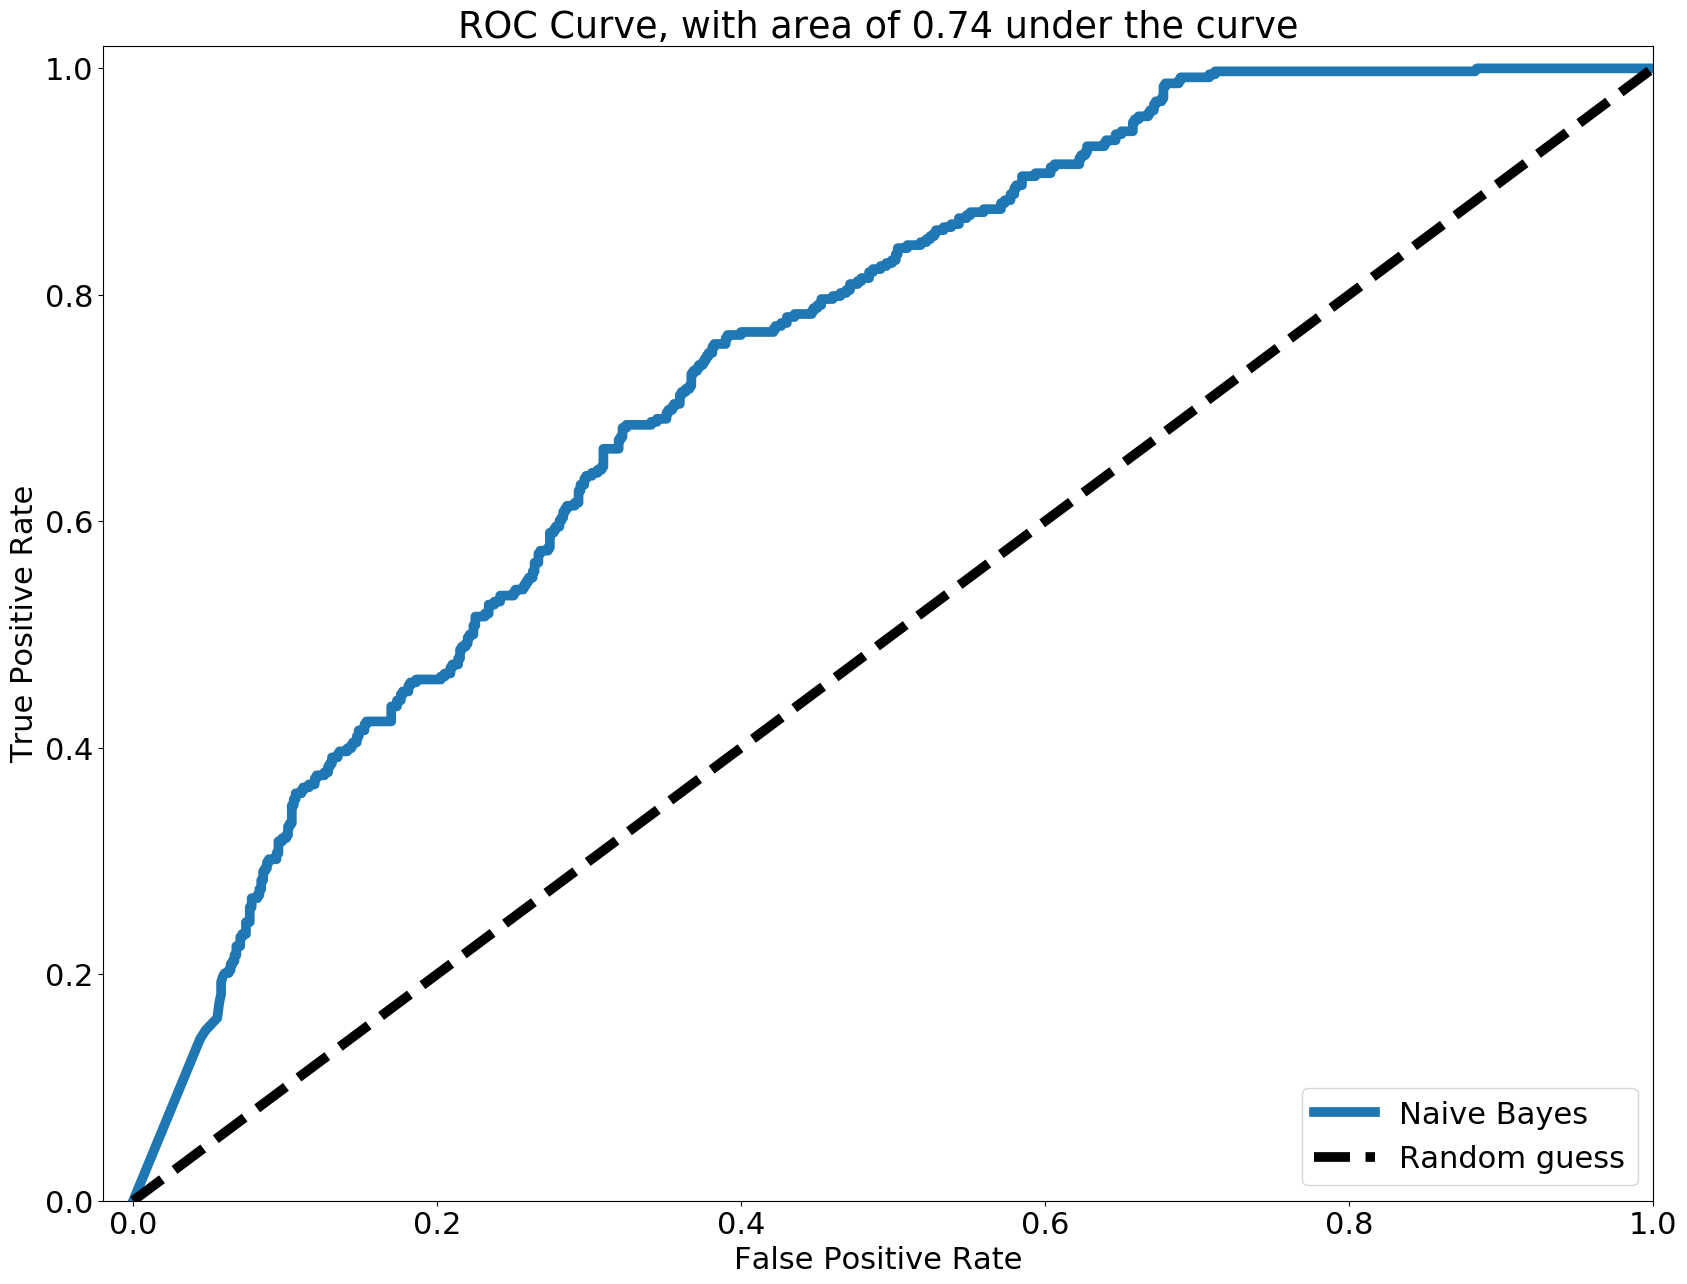

In [86]:
ROC(X_test, y_test, gnb, plot_label='Naive Bayes')

# Now for the KNN

In [87]:
# Number of branches
num_neighbours = range(1, 51)

# List for index
neighbours = list(num_neighbours)

# Number of validations
kfolds = KFold(n_splits = 10)

# Make list for the accuracy for all runs, and the mean accuracy for a tree
accuracy = []
neighbour_accuracy = []
train_result = []
test_result = []

for bastard in num_neighbours:
    _accuracy = []
    _train = []
    _test = []
    
    # Define tree
    knn = KNeighborsClassifier(n_neighbors=bastard, weights="distance")
    
    # Create validation set
    for train_idx, val_idx in kfolds.split(X_dev, y_dev):
        X_train, y_train = X_dev.iloc[train_idx], y_dev.iloc[train_idx]
        X_val, y_val = X_dev.iloc[val_idx], y_dev.iloc[val_idx]
        
        # Fit and predict training data
        knn = knn.fit(X_train, y_train)
        train_pred = knn.predict(X_train)
        
        # Create ROC for training data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, knn.predict_proba(X_train)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _train.append(roc_auc)
        
        # Predict test data
        y_pred = knn.predict(X_val)
        
        # Create ROC for test data, use area under the curve as measure
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, knn.predict_proba(X_val)[:, 1])
        roc_auc = auc(false_positive_rate, true_positive_rate)
        _test.append(roc_auc)
        
        # Append accuracy score
        _accuracy.append(metrics.accuracy_score(y_val, y_pred))
        
    train_result.append(np.mean(_train))
    test_result.append(np.mean(_test))
    
    accuracy.append(_accuracy)
    neighbour_accuracy.append(np.mean(accuracy[bastard-1]))
    
df_test_result = pd.DataFrame(test_result, index=neighbours).mean(axis=1)
optimal_neighbours = df_test_result[df_test_result==max(df_test_result)].index[0]
print("Optimal neighbours at: " + str(optimal_neighbours) + " neighbours.")
print("With max area of : " + str(max(df_test_result)) + ".")

Optimal neighbours at: 47 neighbours.
With max area of : 0.7711656320383392.


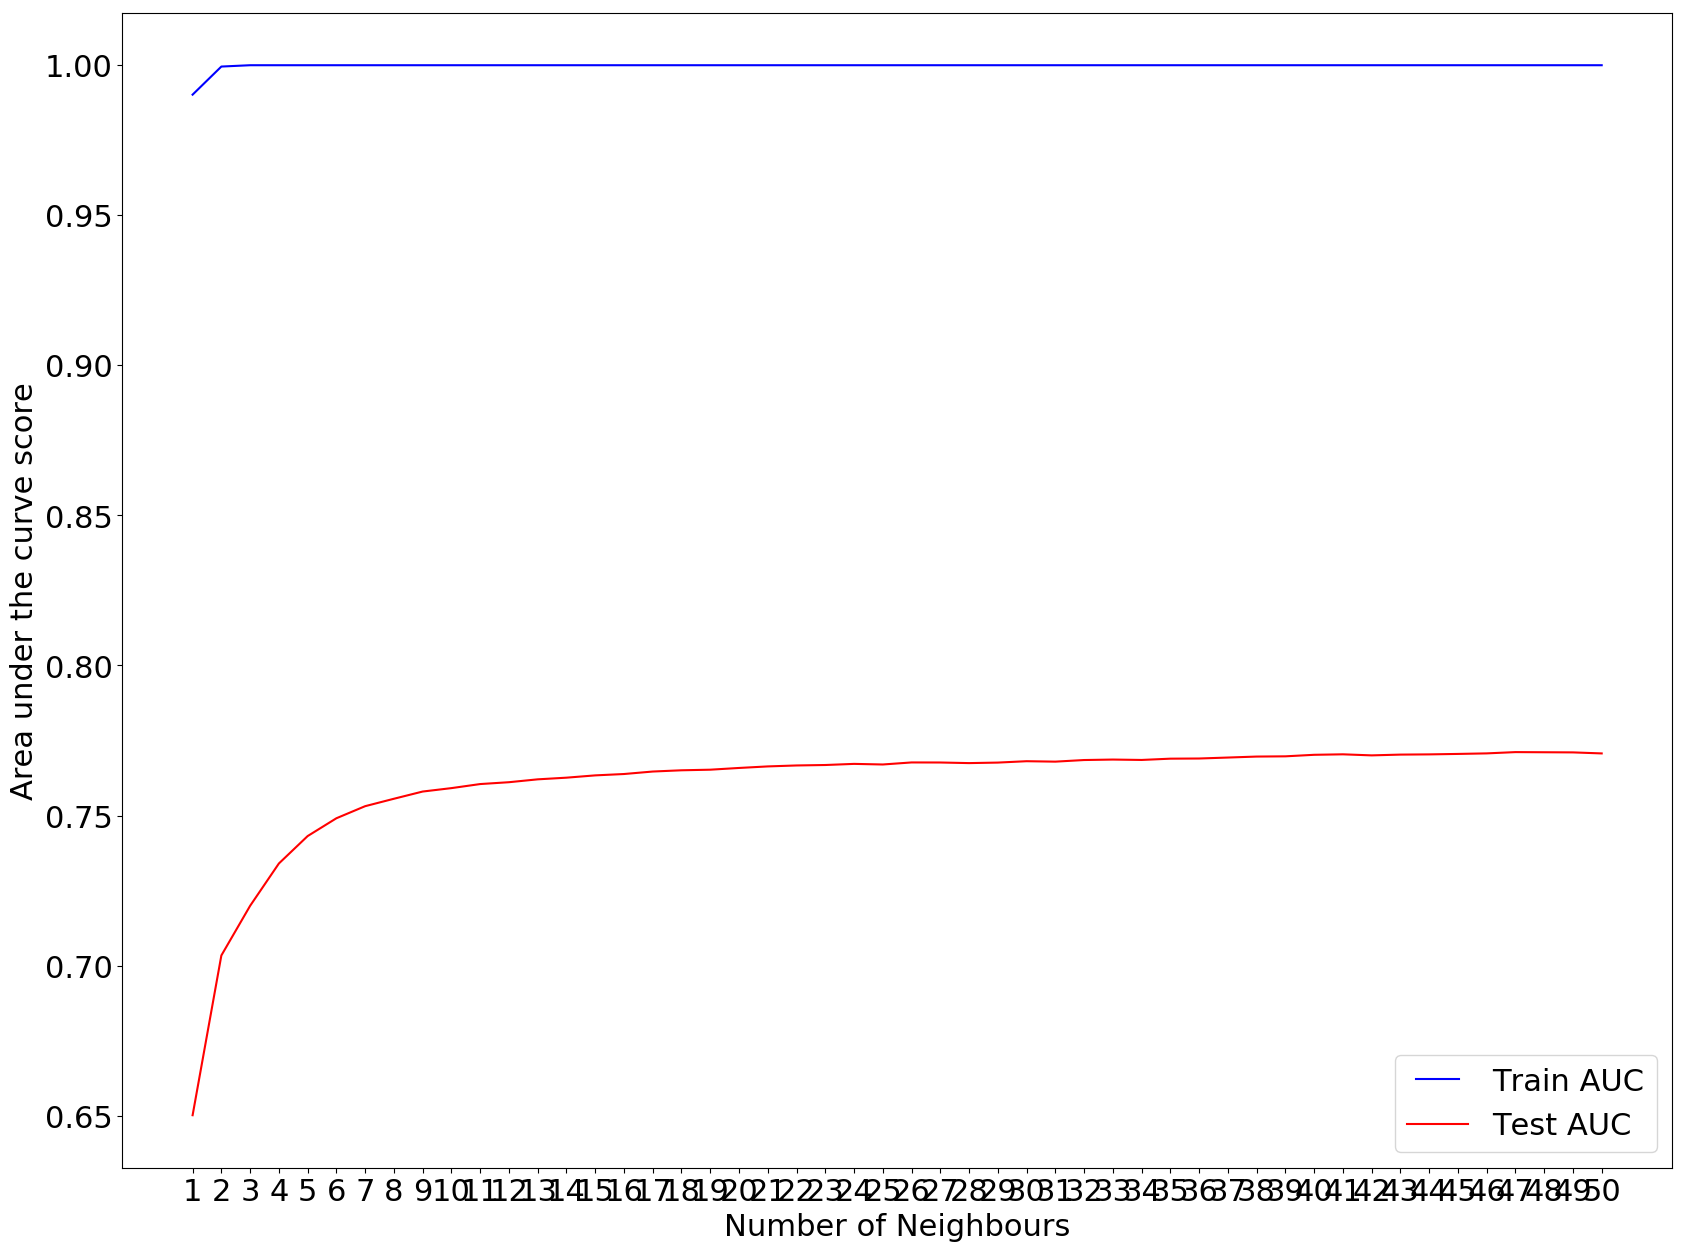

In [89]:
train_test_AUC(num_neighbours, train_result, test_result, local_label='Number of Neighbours')

Increased area under the curve declines quickly, but at around 10 there seems to be miniscule gain. 22 is optimal.

In [90]:
knn = KNeighborsClassifier(n_neighbors=22, weights="distance")
knn.fit(X_dev, y_dev)
y_pred = knn.predict(X_test)

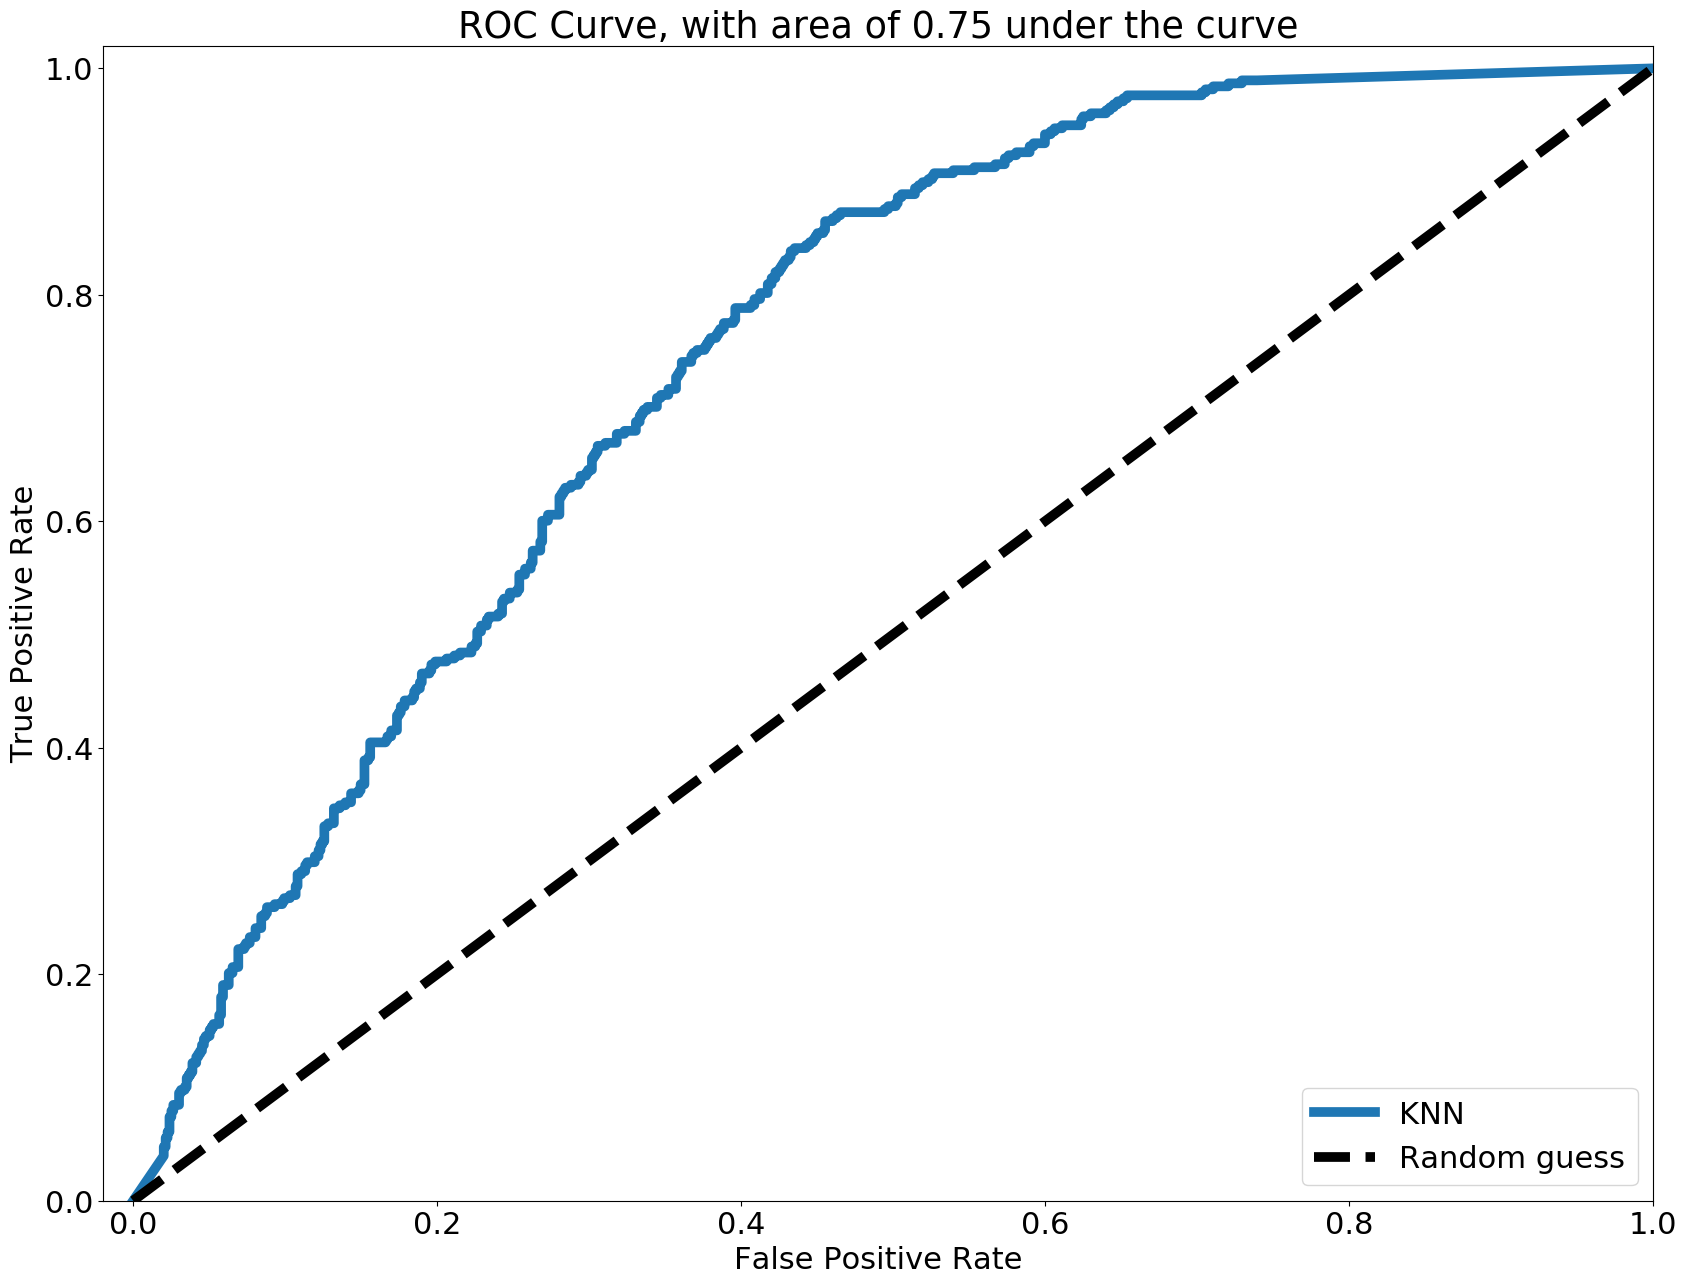

In [91]:
ROC(X_test, y_test, knn, plot_label='KNN')

# Let's now gather our results, to see which model seems to be best suited in predicting orders next month

In [193]:
fit_dict = {DTree_nonPCA: 'Decision Tree', knn: 'Nearest Neighbour', logreg: 'Logistic Regression', gnb: 'Naive Bayes'}

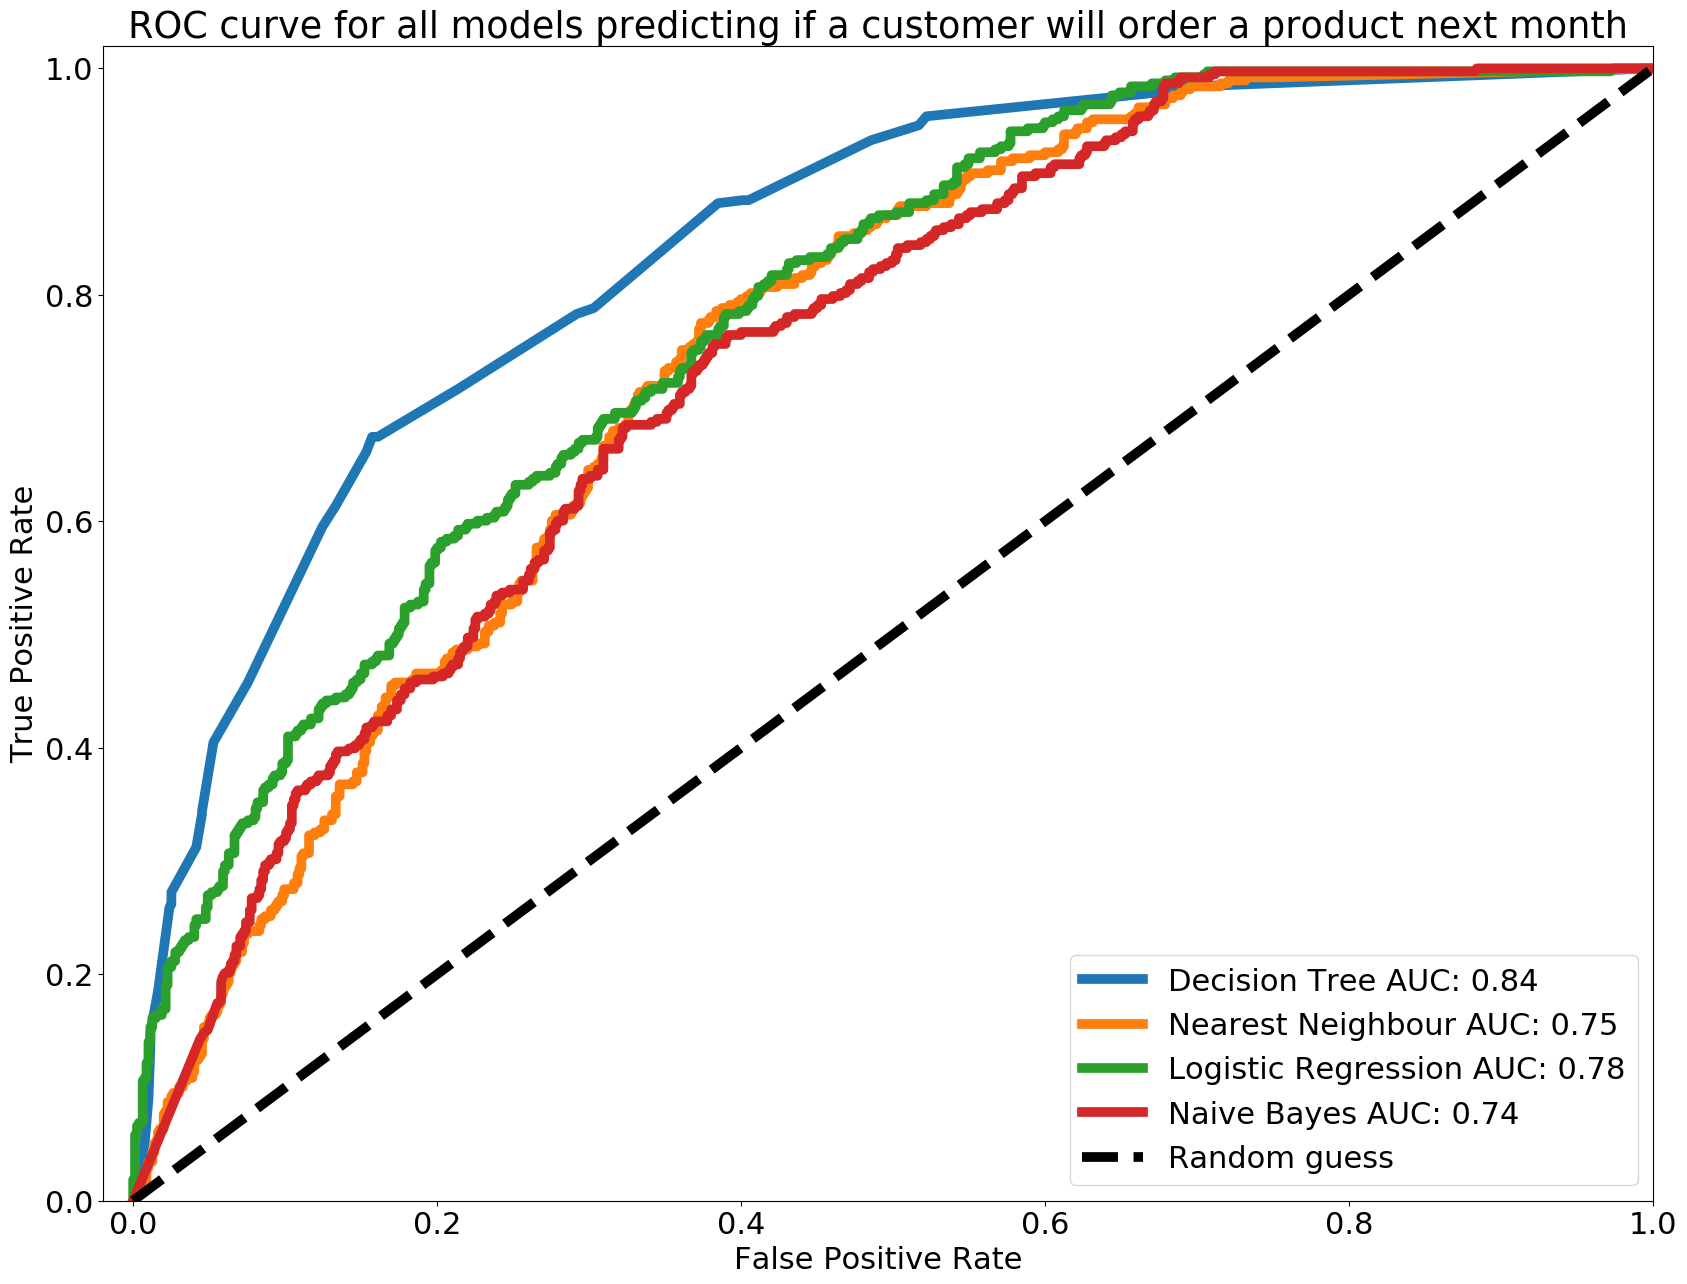

In [194]:
for fitter, plot_label in fit_dict.items():
    prob = fitter.predict_proba(X_test)[:, 1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prob, pos_label=1)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, 
             label=plot_label + ' AUC: ' + str(round(roc_auc, 2)), linewidth=7)

# create plot
plt.plot([0, 1], [0, 1], 'k--', label='Random guess', linewidth=7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for all models predicting if a customer will order a product next month')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc="lower right")
size
font
plt.show()

# Let's see if we can predict returns

In [745]:
y = data_base.loc[:, "returns"]
X = data_base.iloc[:, col_of_pred :]

In [746]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_dev, X_test = my_cluster(X_dev, X_test)

In [747]:
X_dev, X_test = my_cluster(X_dev, X_test)

In [748]:
branch_length = range(1, 21)

# List for index
branches = list(branch_length)

# Number of validations
kfolds = KFold(n_splits = 5)

# Make list for the accuracy for all runs, and the mean accuracy for a tree
accuracy = []

for depth in branch_length:
    DTree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    DTree_returns = DTree.fit(X_dev, y_dev)
    y_pred = DTree_returns.predict(X_test)
    recall = metrics.recall_score(y_test, y_pred)
    accuracy.append(recall)
df_test_result = pd.DataFrame(accuracy, index=branches)
optimal_branches = df_test_result[df_test_result[0]==max(df_test_result[0])].index[0]
print("Optimal branches at: " + str(optimal_branches) + " branches.")
print("With max area of : " + str(max(df_test_result[0])) + ".")

Optimal branches at: 9 branches.
With max area of : 0.17647058823529413.


In [749]:
DTree = DecisionTreeClassifier(criterion='entropy', max_depth=optimal_branches)
DTree_returns = DTree.fit(X_dev, y_dev)
y_pred = DTree_returns.predict(X_test)

In [750]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1156
          1       0.19      0.18      0.18        17

avg / total       0.98      0.98      0.98      1173



In [751]:
metrics.confusion_matrix(y_test, y_pred)

array([[1143,   13],
       [  14,    3]])

We predict returns OK. Lets export this.

In [752]:
# Predict again, and put the true values to merge on the predictions
DTree_prob = pd.DataFrame(DTree_returns.predict_proba(X_test)[:, 1], columns=['probability'])
y_test_export = y_test.reset_index(drop=True)
y_pred_export = pd.DataFrame(y_pred)
DTree_returns_export = DTree_prob.assign(true = y_test_export, predicted = y_pred_export).sort_values(by=['probability'], ascending=False)

In [754]:
DTree_returns_export.to_csv('predicted_returns_fromDTree.csv')

In [587]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_dev, y_dev)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [588]:
metrics.confusion_matrix(y_test, y_pred)

array([[241, 915],
       [  0,  17]])

So this time we predict all returns, but too many times we predict returns when they do not. What about logistic?

In [589]:
logreg = LogisticRegression()
logreg.fit(X_dev, y_dev)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression: ' + str(logreg.score(X_test, y_test)))

Accuracy of logistic regression: 0.9838022165387894


In [590]:
metrics.confusion_matrix(y_test, y_pred)

array([[1154,    2],
       [  17,    0]])

So we actually predict some returns, but they are never true ... Maybe KNN comes to the rescue?

In [732]:
neighbour_length = range(1, 21)

# List for index
neighbours = list(branch_length)

# Number of validations
kfolds = KFold(n_splits = 5)

# Make list for the accuracy for all runs, and the mean accuracy for a tree
accuracy = []

for depth in neighbour_length:
    knn = KNeighborsClassifier(n_neighbors=depth, weights="distance")
    knn_returns = knn.fit(X_dev, y_dev)
    y_pred = knn_returns.predict(X_test)
    recall = metrics.recall_score(y_test, y_pred)
    accuracy.append(recall)
df_test_result = pd.DataFrame(accuracy, index=neighbours)
optimal_neighbour = df_test_result[df_test_result[0]==max(df_test_result[0])].index[0]
print("Optimal branches at: " + str(optimal_branches) + " branches.")
print("With max area of : " + str(max(df_test_result[0])) + ".")

Optimal branches at: 5 branches.
With max area of : 0.11764705882352941.


In [733]:
knn = KNeighborsClassifier(n_neighbors=optimal_neighbour, weights="distance")
knn.fit(X_dev, y_dev)
y_pred = knn.predict(X_test)

In [734]:
print(classification_report(y_test, knn.predict(X_test)))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1156
          1       0.33      0.12      0.17        17

avg / total       0.98      0.98      0.98      1173



In [735]:
print(metrics.confusion_matrix(y_test, y_pred))

[[1152    4]
 [  15    2]]


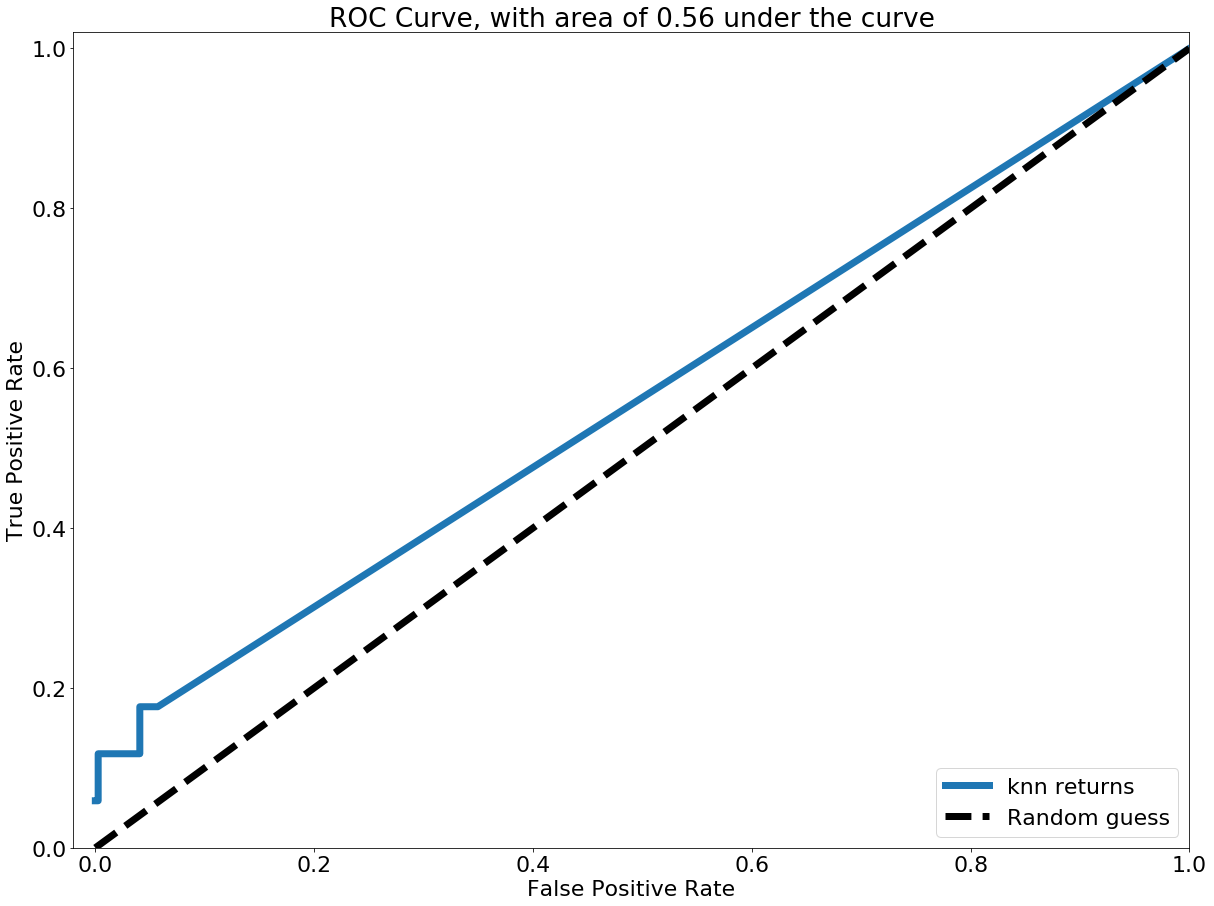

In [736]:
ROC(X_test, y_test, knn, plot_label='knn returns')

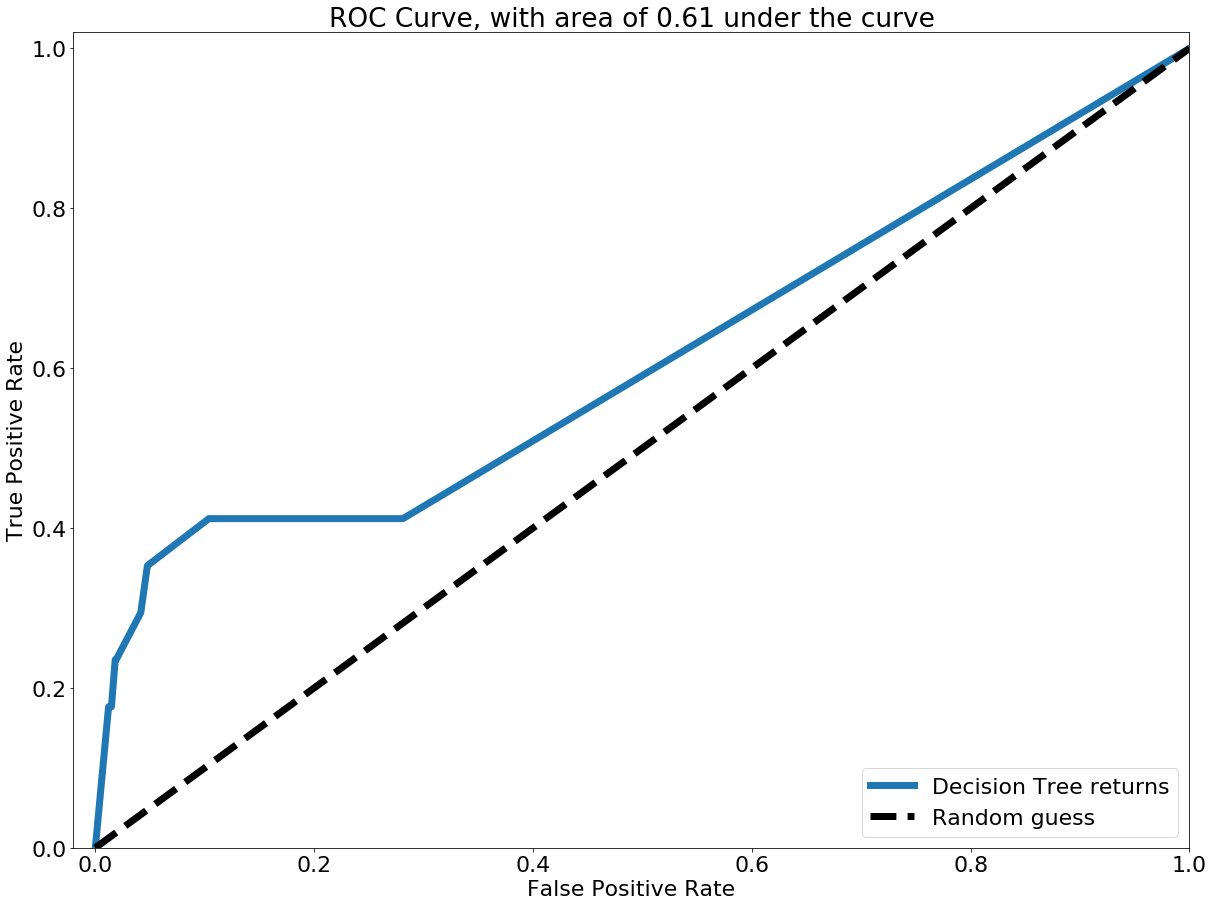

In [739]:
ROC(X_test, y_test, DTree_returns, plot_label='Decision Tree returns')